<a href="https://colab.research.google.com/github/2003UJAN/2003UJAN/blob/main/Flood_Area_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'flood-area-segmentation:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2738852%2F4732950%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240525%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240525T080206Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0181bf1539ba88256c207256244f50354c10dc1592ed76733355effd82e70877b056d1b96171c2bfe404e1996393e90d158098c5ca2152d63ca243c98a8b031a49fde2b0d42f43388b47404bba8def50487e5159698fcffa145602f11cea08816a53c5e4c3acb7e17de1c9d3f3258abdb3d3e945c1490defe348412c0034606b53abe3eb37a1529ade8f8574bd9789f3d4a8f71ae65c73fe00414c309d4df19bd21a5d99fc334dcf4d4a804bff80b2cf2ccbc5ebb2d7bf407a4ef60024f1ef5b46d9863f3a1c546fe0f74b429d0d3f71e2cb0695af38e36ab1647deb8e347e710c96a00458fe5fa01cc6c9051cbf2a912cca28355ea6249d8eabbc97a15e4d17'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 112072442 bytes downloaded
Downloaded and uncompressed: flood-area-segmentation
Data source import complete.


In [2]:
import os
import glob
import cv2
import math
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf # type: ignore
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, UpSampling2D, ReLU # type: ignore
from tensorflow.keras.layers import MaxPool2D, Concatenate, Activation, BatchNormalization # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

import warnings
warnings.filterwarnings('ignore')

In [3]:
WIDTH, HEIGHT, CHANNEL = 256, 256, 3
TRAIN_RATIO, VALIDATION_RATIO, TEST_RATIO = 0.70, 0.15, 0.15
DATASET_PATH = "../input/flood-area-segmentation/"
WEIGHTS_DIR = "model/weights/"
MODEL_DIR = "model/models/"
# source: https://www.kaggle.com/datasets/faizalkarim/flood-area-segmentation

### **Dataset**

In [4]:
image_paths = glob.glob(DATASET_PATH + "Image/" + "*.*")
mask_paths = glob.glob(DATASET_PATH + "Mask/" + "*.*")

image_paths = sorted(image_paths, key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))
mask_paths  = sorted(mask_paths, key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))

len(image_paths), len(mask_paths)

(290, 290)

In [5]:
def pre_process(img_paths, channel):
    images = [Image.open(p).convert(channel).resize((WIDTH, HEIGHT)) for p in img_paths]
    images = np.array(images, dtype=np.float32) / 255.
    return images

images_normalized = pre_process(image_paths, 'RGB')
mask_normalized = pre_process(mask_paths, 'L').reshape(len(mask_paths), WIDTH, HEIGHT, 1)

images_normalized.shape, mask_normalized.shape

((290, 256, 256, 3), (290, 256, 256, 1))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(images_normalized, mask_normalized,
                                                    test_size = 1-TRAIN_RATIO,shuffle=False)
X_val,   X_test, y_val,   y_test = train_test_split(X_test, y_test, shuffle=False,
                                                    test_size = TEST_RATIO/(TEST_RATIO+VALIDATION_RATIO))

print(X_train.shape, y_train.shape,'\n',
      X_test.shape,  y_test.shape,'\n',
      X_val.shape,   y_val.shape)

(202, 256, 256, 3) (202, 256, 256, 1) 
 (44, 256, 256, 3) (44, 256, 256, 1) 
 (44, 256, 256, 3) (44, 256, 256, 1)


### **Utils**

In [7]:
def display_images(img1, img2, img3, title=True):
    row, col = 1, 3
    plt.subplots(row, col, dpi=200)

    plt.subplot(row, col, 1)
    if(title):plt.title("Image")
    plt.imshow(np.clip(img1, 0, 1))
    plt.axis('off')

    plt.subplot(row, col, 2)
    if(title):plt.title("Mask")
    plt.imshow(np.clip(img2, 0, 1))
    plt.axis('off')

    plt.subplot(row, col, 3)
    if(title):plt.title("Predicted")
    plt.imshow(np.clip(img3, 0, 1))
    plt.axis('off')

    plt.show()

In [8]:
def overlay(image, mask, color, alpha):
    masked_image = image.copy()

    colored_mask = np.expand_dims(mask, 0).repeat(3, axis=0)
    colored_mask = np.moveaxis(colored_mask, 0, -1)

    masked = np.ma.MaskedArray(masked_image, mask=colored_mask, fill_value=color)

    image_overlay = masked.filled()
    image_combined = cv2.addWeighted(masked_image, 1 - alpha, image_overlay, alpha, 0)

    return image_combined

In [9]:
def psnr(img1, img2):
    return tf.image.psnr(img1, img2, max_val=255).numpy()

def ssim(img1, img2):
    return tf.image.ssim(img1, img2, max_val=255).numpy()

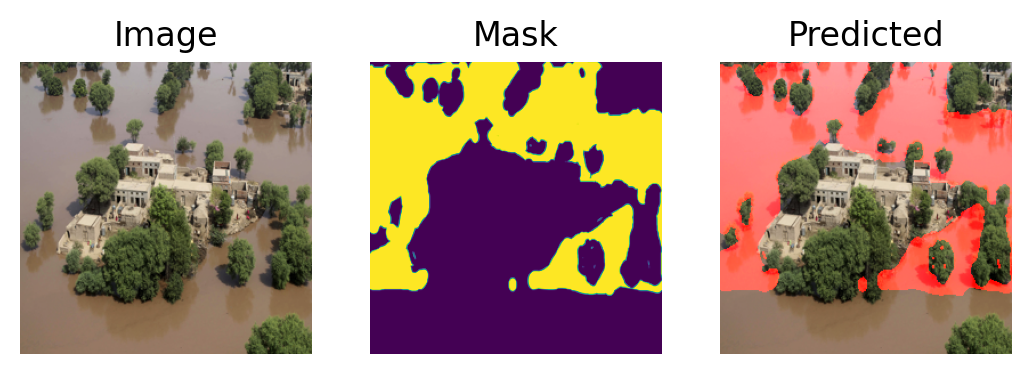

In [10]:
rnd_img_idx = random.randint(0, len(X_train))
X_img = X_train[rnd_img_idx,:,:,:]
y_img = y_train[rnd_img_idx,:,:,:]

y_img_overlay = overlay(X_img, y_img, color=(255,0,0), alpha=0.1) # type: ignore
display_images(X_img, y_img, y_img_overlay, title=True) # type: ignore

### **Model Design**

<img src="https://raw.githubusercontent.com/AliAtes/sau-dersler/main/Derin%20%C3%96%C4%9Frenme%20ve%20Evri%C5%9Fimli%20Sinir%20A%C4%9Flar%C4%B1/Unet%20Segmentation/unet-1.jpg" /> <br>
**source:** https://www.youtube.com/@DigitalSreeni

In [11]:
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same")(inputs) # https://keras.io/api/layers/initializers/
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
    return x

In [12]:
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D(pool_size=(2,2))(x)
    return x, p

In [13]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(filters=num_filters, kernel_size=(2,2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [14]:
def UNet(input_size):
    input_layer_nodes = 8
    input = Input(input_size)
    # s: output of conv block | p: output of max pooling
    s1, p1 = encoder_block(input,input_layer_nodes * 1)
    s2, p2 = encoder_block(p1,   input_layer_nodes * 2)
    s3, p3 = encoder_block(p2,   input_layer_nodes * 4)
    s4, p4 = encoder_block(p3,   input_layer_nodes * 8)

    b1 = conv_block(p4, input_layer_nodes * 16)   # Bridge

    # d: output of decoder block
    d1 = decoder_block(b1, s4, input_layer_nodes * 8)
    d2 = decoder_block(d1, s3, input_layer_nodes * 4)
    d3 = decoder_block(d2, s2, input_layer_nodes * 2)
    d4 = decoder_block(d3, s1, input_layer_nodes * 1)

    output = Conv2D(filters=1, kernel_size=(1,1), padding="same", activation="sigmoid")(d4)

    return tf.keras.Model(input, output, name="U-Net")

In [15]:
unet = UNet((WIDTH, HEIGHT, CHANNEL))
unet.compile(optimizer="adam", loss='binary_crossentropy', metrics=['acc'])
unet.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 8)          224       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 8)          0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 8)          584       ['dropout[0][0]']             
                                                                                              

### **Training Callbacks**

In [16]:
# Save model and logs on training with callbacks

checkpoints_path = "model/checkpoints/model-improvement-{epoch:02d}-{val_acc:.2f}.keras"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoints_path, verbose = 1,
                                                monitor='val_acc', save_best_only = True, mode='max',  # vall_acc arttıkça kaydet.
                                                #monitor='loss', save_best_only = True, mode='min',    # loss azaldıkça kaydet.
                                                #save_weights_only=True,                               # sadece weight'leri kaydet.
                                                )

early_stop = tf.keras.callbacks.EarlyStopping(patience = 5, # Monitorde artış olmayan epoch sayısı
                                              verbose = 1, monitor = 'val_loss')

log_csv = tf.keras.callbacks.CSVLogger(os.getcwd() + '\\logs\\train_log.csv', separator=',', append=True)

tensorboard = tf.keras.callbacks.TensorBoard(log_dir = os.getcwd() + '\\logs', write_images=True, histogram_freq=2,
                                             write_steps_per_second=True, update_freq='epoch',)

"""from torch.utils.tensorboard import SummaryWriter
model = ...
dummy_input = ...
writer = SummaryWriter(f'logs/graph')
writer.add_graph(model, dummy_input)
writer.close()"""

callback_list = [checkpoint, tensorboard, log_csv]

### **Start Training**

In [17]:
results = unet.fit(
    X_train,
    y_train,
    batch_size = 32,
    epochs = 100,
    #validation_split = 0.1,
    validation_data = (X_val, y_val),
    callbacks = callback_list
)

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.6904 - acc: 0.5674
Epoch 1: val_acc improved from -inf to 0.43868, saving model to model/checkpoints/model-improvement-01-0.44.keras
7/7 [==============================] - 25s 1s/step - loss: 0.6904 - acc: 0.5674 - val_loss: 0.6944 - val_acc: 0.4387
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.6811 - acc: 0.5830
Epoch 2: val_acc improved from 0.43868 to 0.43904, saving model to model/checkpoints/model-improvement-02-0.44.keras
7/7 [==============================] - 2s 265ms/step - loss: 0.6811 - acc: 0.5830 - val_loss: 0.6812 - val_acc: 0.4390
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.6738 - acc: 0.5911
Epoch 3: val_acc improved from 0.43904 to 0.43906, saving model to model/checkpoints/model-improvement-03-0.44.keras
7/7 [==============================] - 2s 309ms/step - loss: 0.6738 - acc: 0.5911 - val_loss: 0.6744 - val_acc: 0.4391
Epoch 4/100
7/7 [================

In [18]:
#%load_ext tensorboard
#%tensorboard --logdir logs

### **Manually Save the Model**

In [19]:
#os.makedirs(WEIGHTS_DIR, exist_ok=True)
#unet.save_weights(WEIGHTS_DIR + "model_weights.weights.h5")

In [20]:
#unet = UNet(weights=None)
#unet.load_weights(WEIGHTS_DIR + "model_weights.weights.h5")
#unet.summary()

In [21]:
#os.makedirs(MODEL_DIR, exist_ok=True)
#unet.save(MODEL_DIR + "model.keras")

In [22]:
#unet_loaded = tf.keras.models.load_model(MODEL_DIR + "model.keras")
#unet_loaded.summary()

### **Model Accuracy on Training Data**

acc: 0.8811370730400085 val_acc 0.8598587512969971


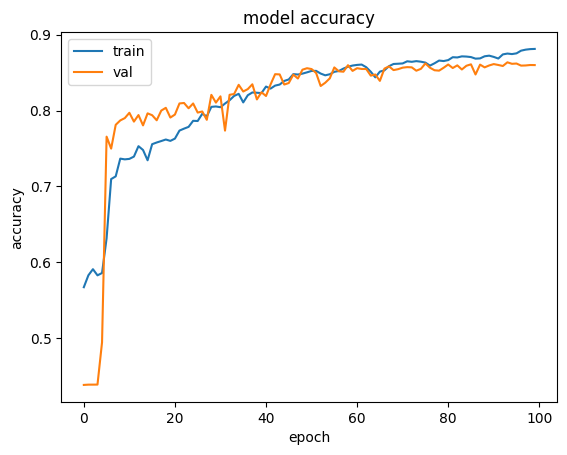

In [23]:
print("acc:", results.history['acc'][-1], "val_acc", results.history['val_acc'][-1])

plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### **Model Loss on Training Data**

loss: 0.2327747344970703 val_acc 0.3323169946670532


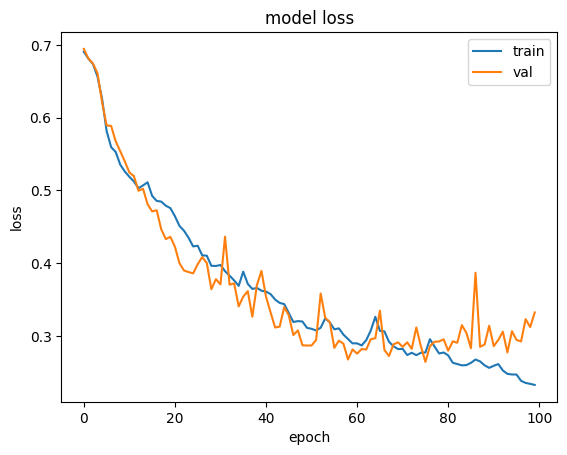

In [24]:
print("loss:", results.history['loss'][-1], "val_acc", results.history['val_loss'][-1])

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### **Evaluate on Test Data**

In [25]:
results = unet.evaluate(X_test, y_test, batch_size=1)
print("loss:", results[0], "acc:", results[1])

44/44 [==============================] - 1s 4ms/step - loss: 0.3700 - acc: 0.8273
loss: 0.3700125515460968 acc: 0.8272674083709717


### **Prediction**

In [26]:
idx = random.randint(0, len(X_train))

preds_train = unet.predict(X_train)
preds_val   = unet.predict(X_val)
preds_test  = unet.predict(X_test)

preds_train_t = (preds_train > 0.5).astype(np.float32)
preds_val_t   = (preds_val   > 0.5).astype(np.float32)
preds_test_t  = (preds_test  > 0.5).astype(np.float32)

2/2 [==============================] - 0s 25ms/step


In [27]:
preds_train_t.shape, preds_val_t.shape, preds_test_t.shape

((202, 256, 256, 1), (44, 256, 256, 1), (44, 256, 256, 1))

### **Plot**

PSNR: 61.639206 | SSIM: 0.9965308


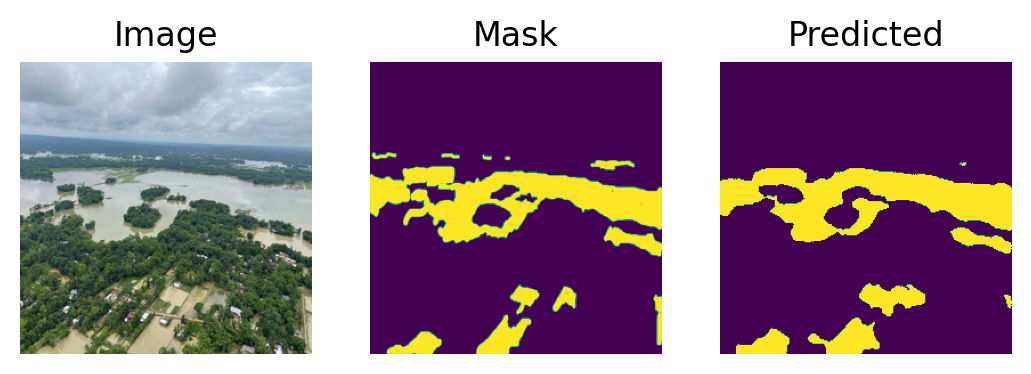

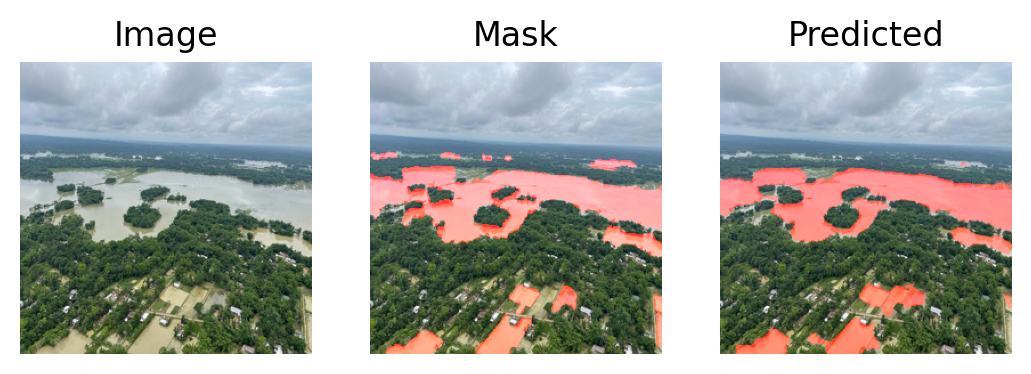

In [28]:
# Select a random index from training set
i = random.randint(0, len(preds_train_t))

print("PSNR:", psnr(y_train[i], preds_train_t[i]), '|',
      "SSIM:", ssim(y_train[i], preds_train_t[i]))

display_images(X_train[i], y_train[i], preds_train_t[i])

y_train_overlay = overlay(X_train[i], y_train[i],       color=(255,0,0), alpha=0.1)
y_pred_overlay  = overlay(X_train[i], preds_train_t[i], color=(255,0,0), alpha=0.25)

display_images(X_train[i], y_train_overlay, y_pred_overlay)


### **Model Analyse**

In [29]:
os.makedirs(MODEL_DIR, exist_ok=True)
unet.save(MODEL_DIR + "model.keras")

In [30]:
unet_loaded = tf.keras.models.load_model(MODEL_DIR + "model.keras")
unet_loaded.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 8)          224       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 8)          0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 8)          584       ['dropout[0][0]']             
                                                                                              

In [31]:
def get_conv_blocks(model):
    conv_blocks = []
    for l, layer in enumerate(model.layers):
        if 'conv' in layer.name:
            filters , bias = layer.get_weights()
            conv_blocks.append({"idx":l, "type":layer.name, "shape":filters.shape})
    return conv_blocks

get_conv_blocks(unet_loaded)
# (3x3 filter, 3 channel, 16 filter)

[{'idx': 1, 'type': 'conv2d', 'shape': (3, 3, 3, 8)},
 {'idx': 3, 'type': 'conv2d_1', 'shape': (3, 3, 8, 8)},
 {'idx': 5, 'type': 'conv2d_2', 'shape': (3, 3, 8, 16)},
 {'idx': 7, 'type': 'conv2d_3', 'shape': (3, 3, 16, 16)},
 {'idx': 9, 'type': 'conv2d_4', 'shape': (3, 3, 16, 32)},
 {'idx': 11, 'type': 'conv2d_5', 'shape': (3, 3, 32, 32)},
 {'idx': 13, 'type': 'conv2d_6', 'shape': (3, 3, 32, 64)},
 {'idx': 15, 'type': 'conv2d_7', 'shape': (3, 3, 64, 64)},
 {'idx': 17, 'type': 'conv2d_8', 'shape': (3, 3, 64, 128)},
 {'idx': 19, 'type': 'conv2d_9', 'shape': (3, 3, 128, 128)},
 {'idx': 20, 'type': 'conv2d_transpose', 'shape': (2, 2, 64, 128)},
 {'idx': 22, 'type': 'conv2d_10', 'shape': (3, 3, 128, 64)},
 {'idx': 24, 'type': 'conv2d_11', 'shape': (3, 3, 64, 64)},
 {'idx': 25, 'type': 'conv2d_transpose_1', 'shape': (2, 2, 32, 64)},
 {'idx': 27, 'type': 'conv2d_12', 'shape': (3, 3, 64, 32)},
 {'idx': 29, 'type': 'conv2d_13', 'shape': (3, 3, 32, 32)},
 {'idx': 30, 'type': 'conv2d_transpose_2'

### **Plot Conv Filters**

In [32]:
def plot_filters(filters):
    num_channel, num_filters = filters.shape[-2], filters.shape[-1]

    fig = plt.figure(figsize=(num_channel, num_filters))
    ix = 1
    for i in range(num_filters):
        filter = filters[:,:,:,i]
        for ch in range(num_channel):
            plt.subplot(num_filters, num_channel, ix)
            plt.title(f"filter: {i+1}")
            plt.imshow(filter[:,:,ch], cmap='gray')
            plt.axis('off')
            ix += 1
    plt.show()

(3, 3, 8, 8)


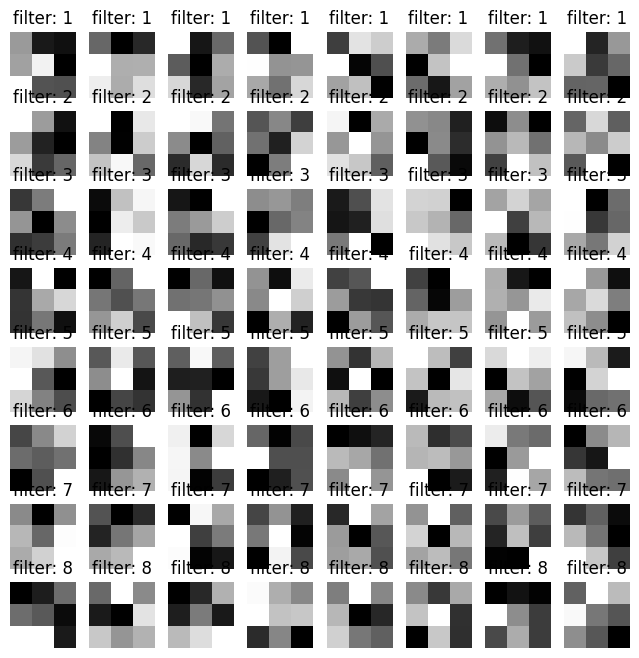

In [33]:
filters, bias = unet_loaded.layers[3].get_weights()

print(filters.shape) # (3x3 filter_size, num_channel, num_filter)
plot_filters(filters)

### **Plot Conv Features**

In [34]:
umodel1 = tf.keras.models.Model(inputs=unet_loaded.input, outputs=unet_loaded.layers[1].output)
umodel1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 8)       224       
                                                                 
Total params: 224 (896.00 Byte)
Trainable params: 224 (896.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


(256, 256, 3) (256, 256, 1)


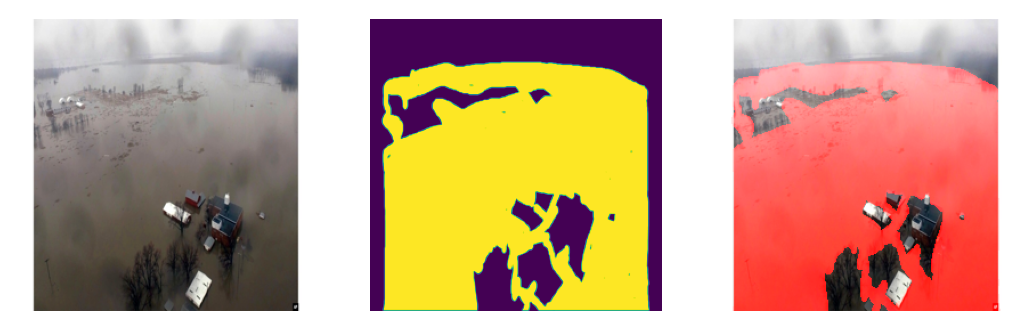

In [35]:
rnd_sample_idx = random.randint(0, len(X_train))
X_sample = X_train[rnd_sample_idx,:,:,:]
y_sample = y_train[rnd_sample_idx,:,:,:]
print(X_sample.shape, y_sample.shape)

y_sample_overlay = overlay(X_sample, y_sample, color=(255,0,0), alpha=0.1)
display_images(X_sample, y_sample, y_sample_overlay, title=False)

In [36]:
X_sample = X_sample[np.newaxis,...]

umodel1_features = umodel1.predict(X_sample)

#X_sample.shape: 256x256x3 --> 1x256x256x3 (batch, width, height, channel)
#umodel1_features.shape:      1x256x256x16 (batch, width, height, num_feature)

X_sample.shape, umodel1_features.shape

1/1 [==============================] - 0s 169ms/step


((1, 256, 256, 3), (1, 256, 256, 8))

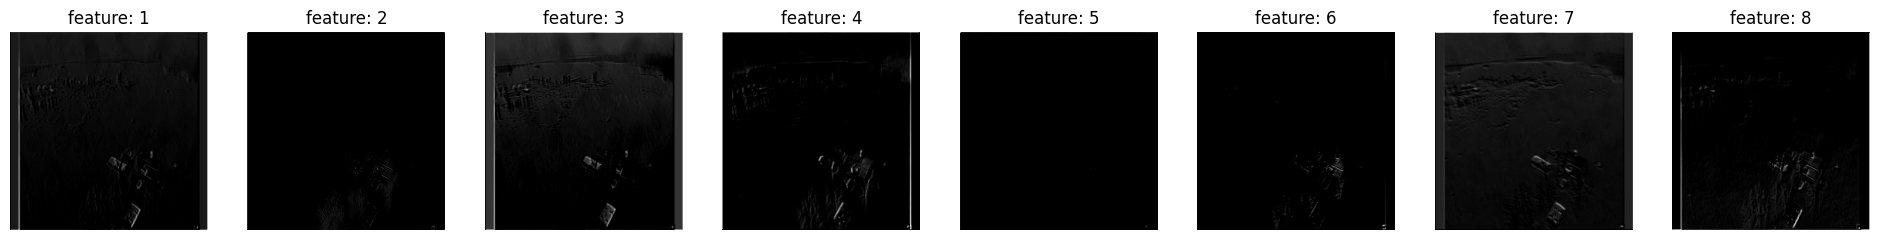

In [37]:
def plot_features(conv_features):
    num_features = conv_features.shape[-1]
    row, col = math.ceil(num_features/8), 8
    fig = plt.figure(figsize=(col*3,row*3))
    for i in range(0, num_features):
        plt.subplot(row, col, i+1)
        plt.title(f"feature: {i+1}")
        plt.imshow(conv_features[0,:,:,i], cmap='gray')
        plt.axis('off')
    plt.show()

plot_features(umodel1_features)

### **Plot All Features**

In [38]:
umodel2 = tf.keras.models.load_model("model/models/model.keras")
umodel2_outputs = [layer.output for layer in umodel2.layers if 'conv' in layer.name]

umodel2 = tf.keras.models.Model(inputs=umodel2.input, outputs=umodel2_outputs)
umodel2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 8)          224       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 8)          0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 8)          584       ['dropout[0][0]']             
                                                                                            

In [39]:
umodel2_feature_maps = umodel2.predict(X_sample)

for i, feature in enumerate(umodel2_feature_maps):
    print(f"Feature map-{i} ({umodel2.layers[i]}) output:", feature.shape)
    # (batch, widh, height, num_feature)

1/1 [==============================] - 0s 273ms/step
Feature map-0 (<keras.src.engine.input_layer.InputLayer object at 0x79ea4044ecb0>) output: (1, 256, 256, 8)
Feature map-1 (<keras.src.layers.convolutional.conv2d.Conv2D object at 0x79ea40584f40>) output: (1, 256, 256, 8)
Feature map-2 (<keras.src.layers.regularization.dropout.Dropout object at 0x79ea42678550>) output: (1, 128, 128, 16)
Feature map-3 (<keras.src.layers.convolutional.conv2d.Conv2D object at 0x79ea4044f880>) output: (1, 128, 128, 16)
Feature map-4 (<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x79ea425015a0>) output: (1, 64, 64, 32)
Feature map-5 (<keras.src.layers.convolutional.conv2d.Conv2D object at 0x79ea42500a60>) output: (1, 64, 64, 32)
Feature map-6 (<keras.src.layers.regularization.dropout.Dropout object at 0x79ea42502c80>) output: (1, 32, 32, 64)
Feature map-7 (<keras.src.layers.convolutional.conv2d.Conv2D object at 0x79ea42502f50>) output: (1, 32, 32, 64)
Feature map-8 (<keras.src.layers.pool

Feature map-0 <keras.src.engine.input_layer.InputLayer object at 0x79ea4044ecb0> output: (1, 256, 256, 8)


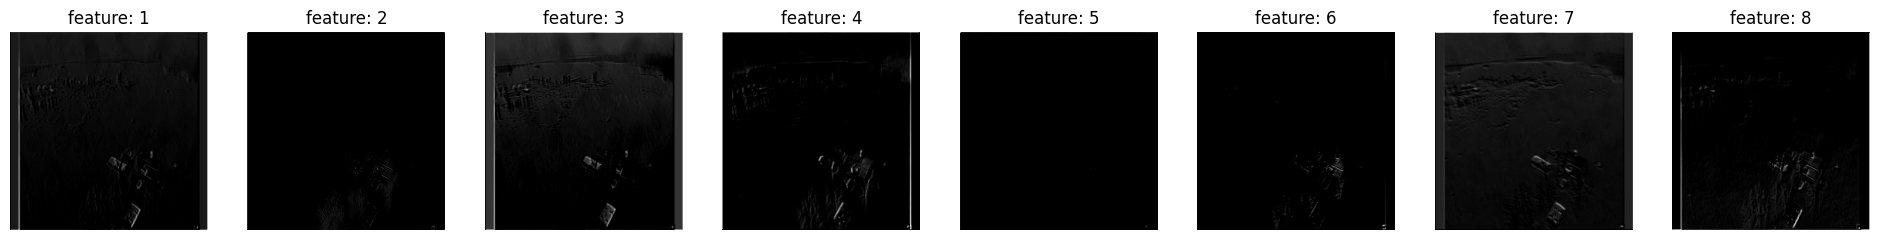

Feature map-1 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x79ea40584f40> output: (1, 256, 256, 8)


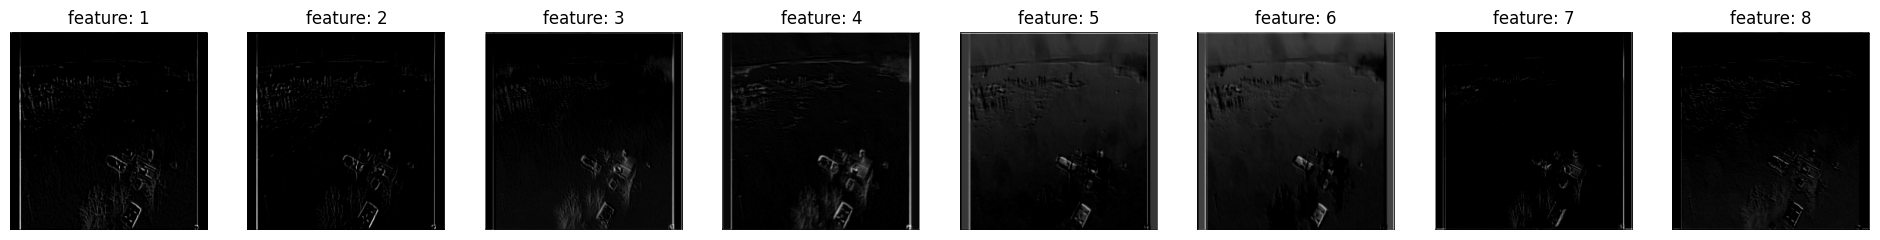

Feature map-2 <keras.src.layers.regularization.dropout.Dropout object at 0x79ea42678550> output: (1, 128, 128, 16)


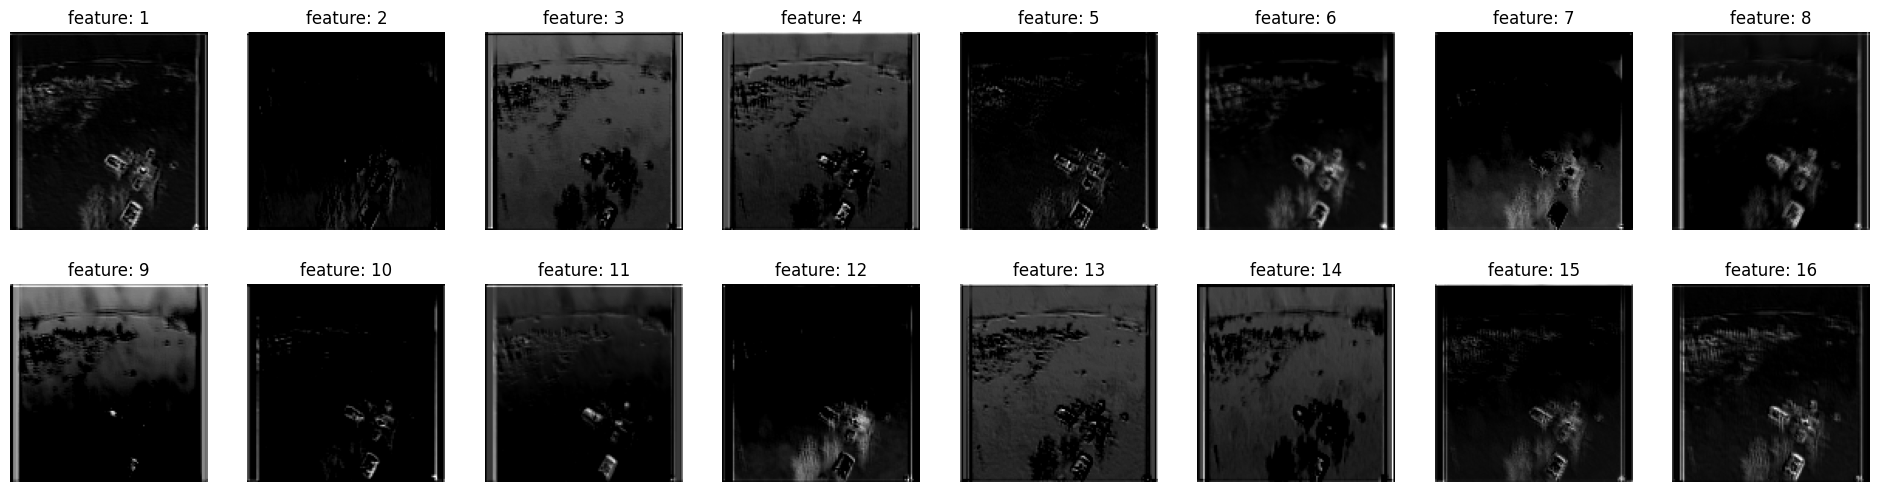

Feature map-3 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x79ea4044f880> output: (1, 128, 128, 16)


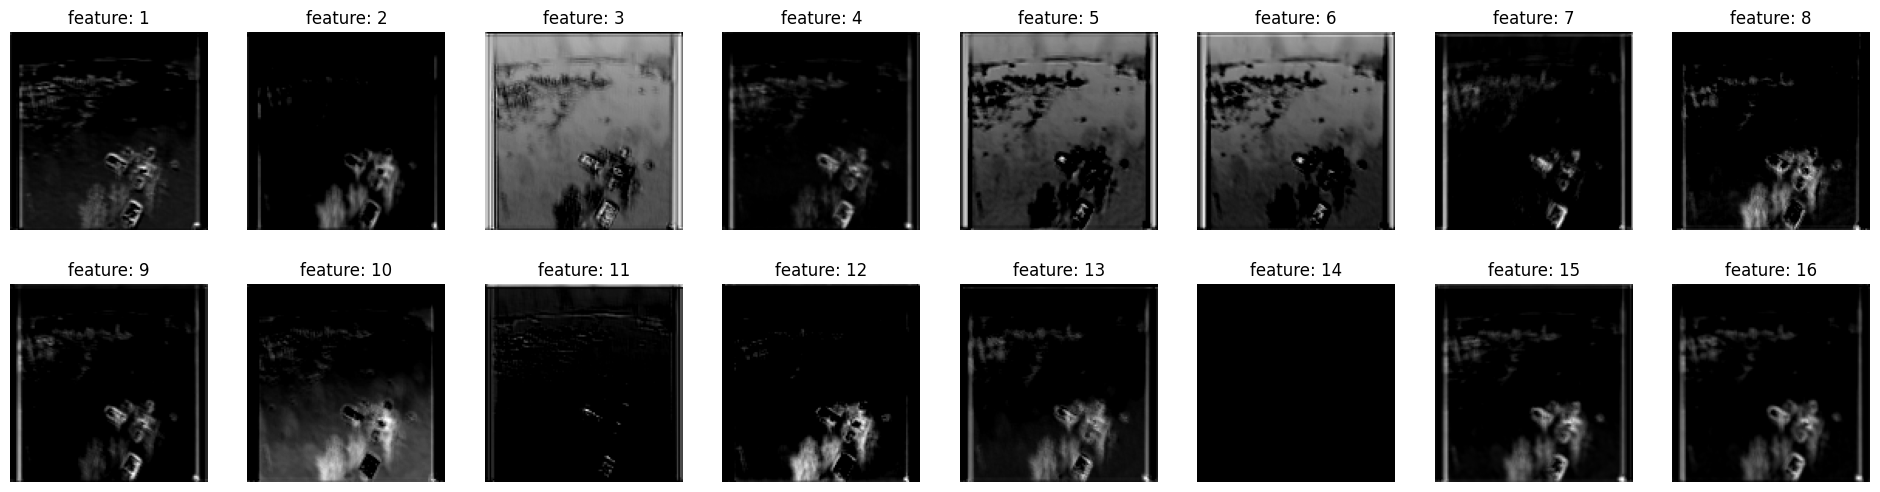

Feature map-4 <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x79ea425015a0> output: (1, 64, 64, 32)


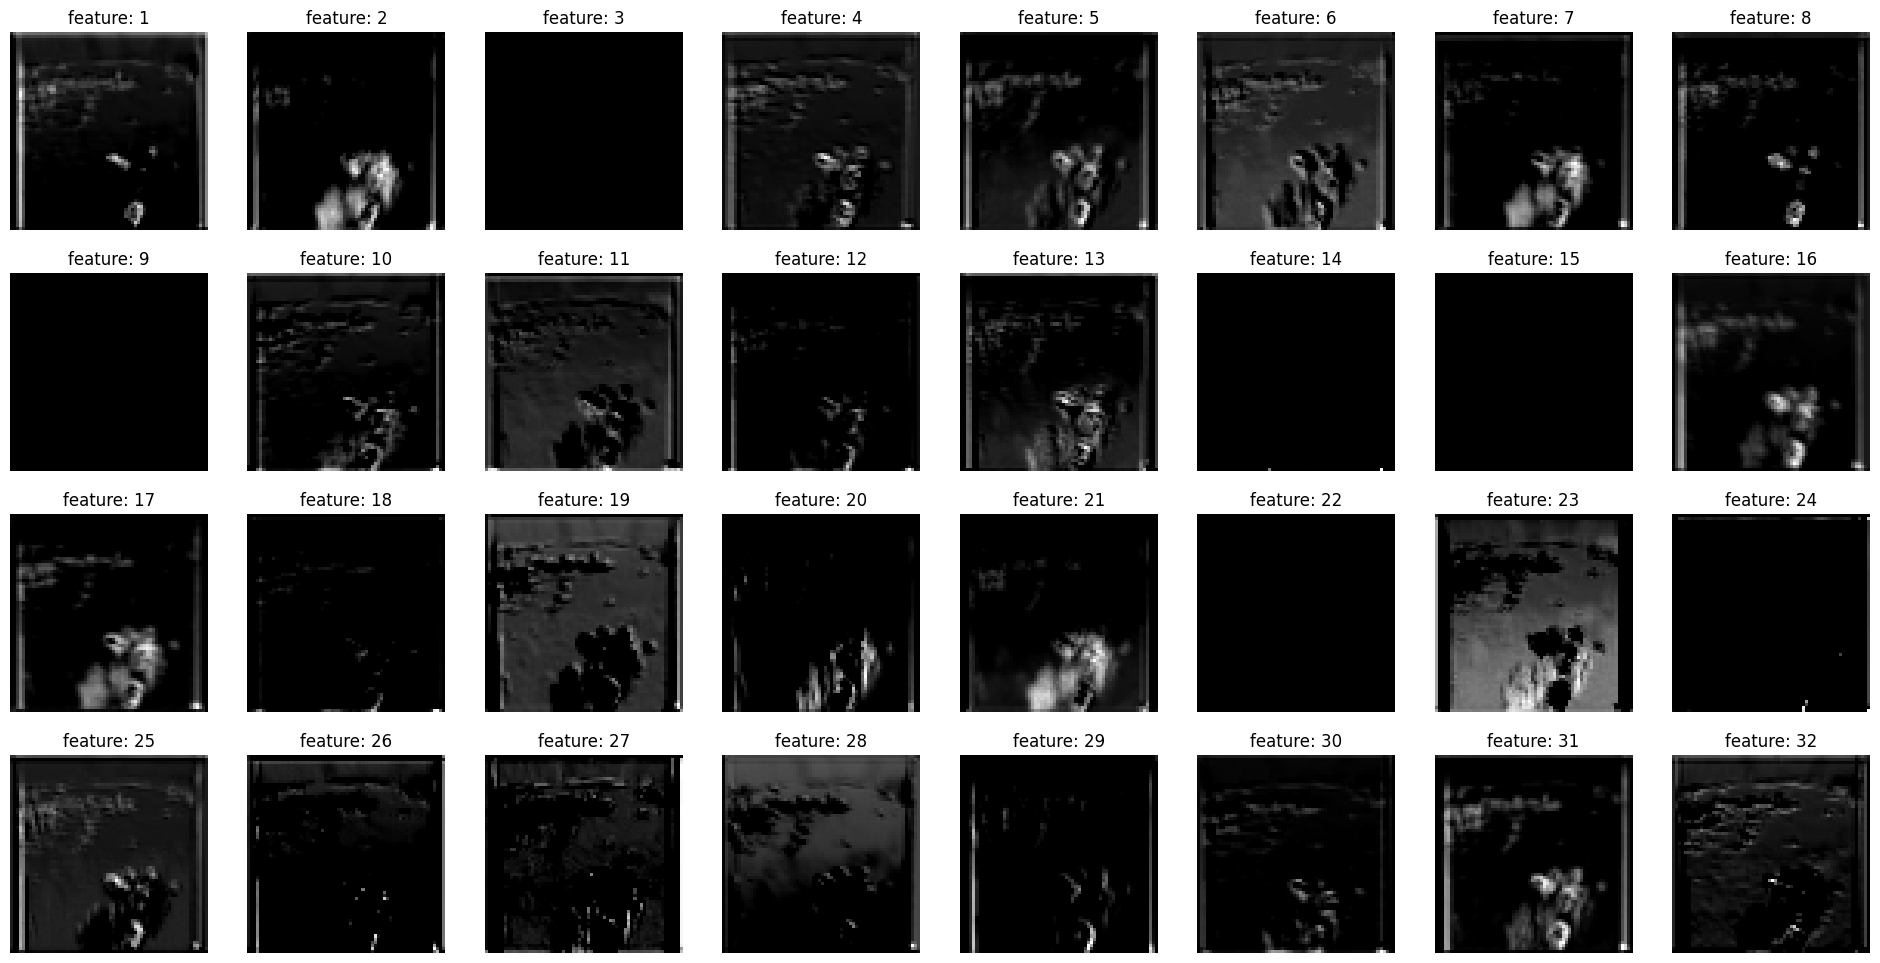

Feature map-5 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x79ea42500a60> output: (1, 64, 64, 32)


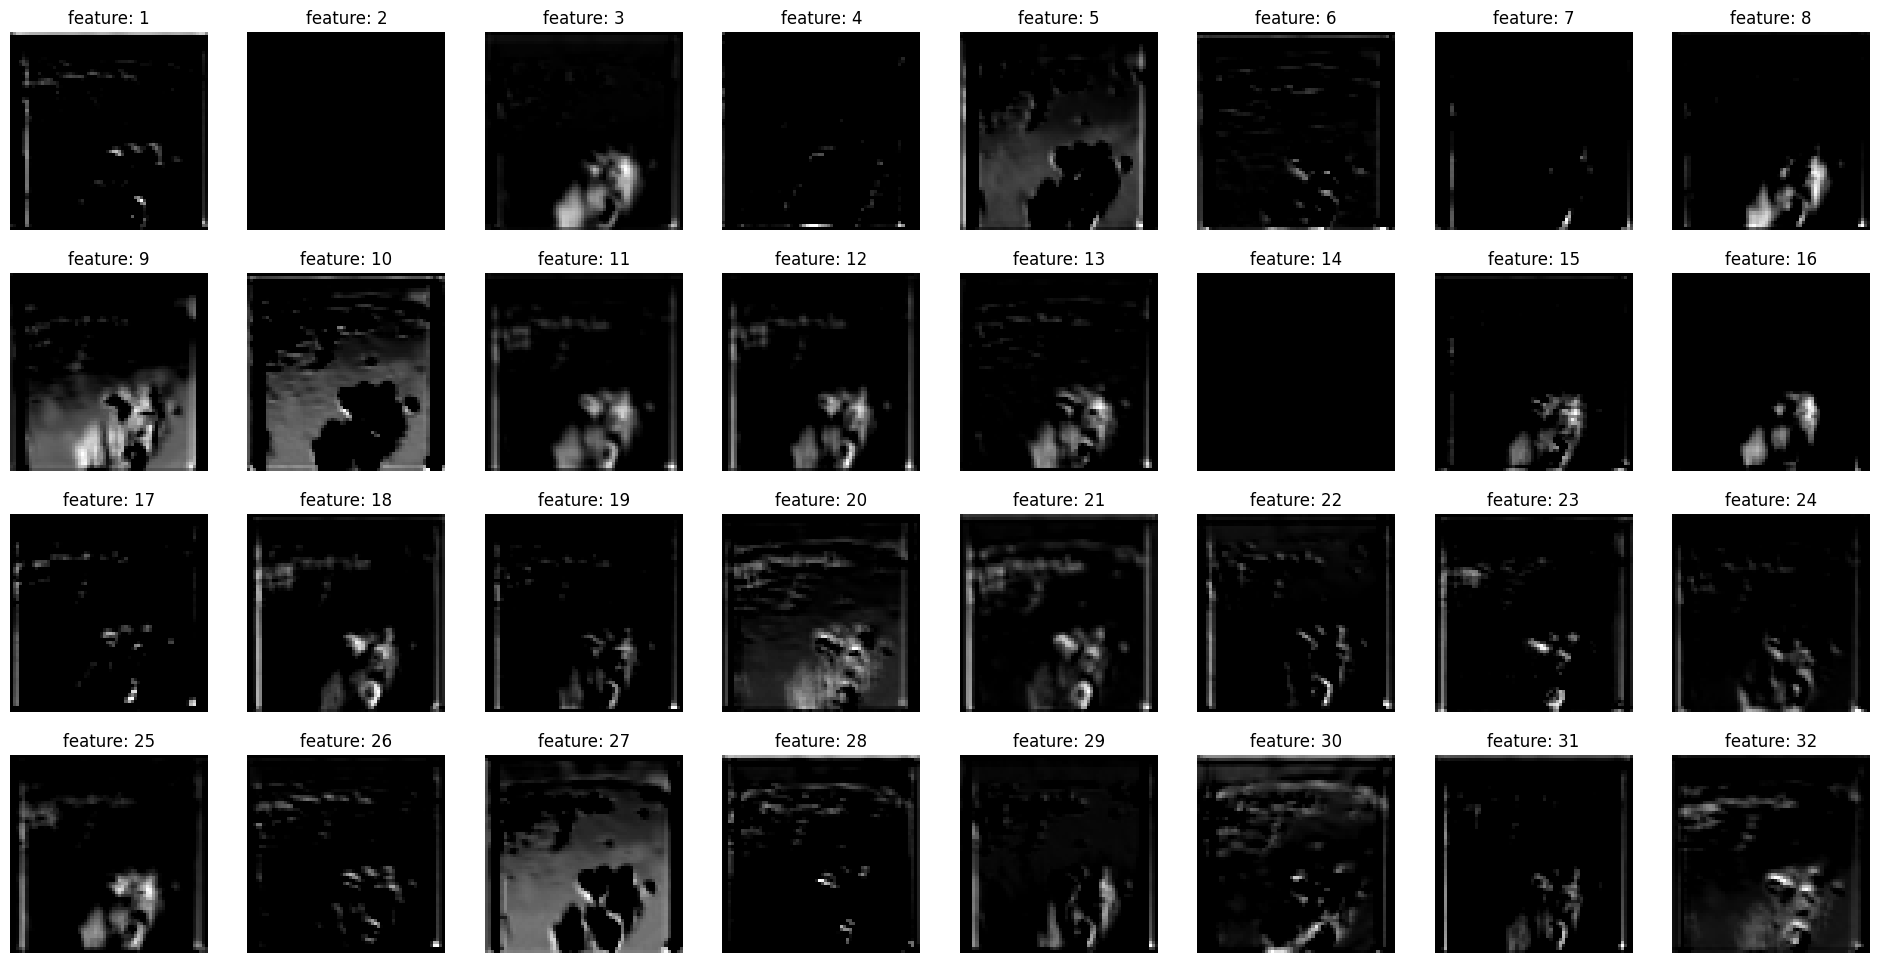

Feature map-6 <keras.src.layers.regularization.dropout.Dropout object at 0x79ea42502c80> output: (1, 32, 32, 64)


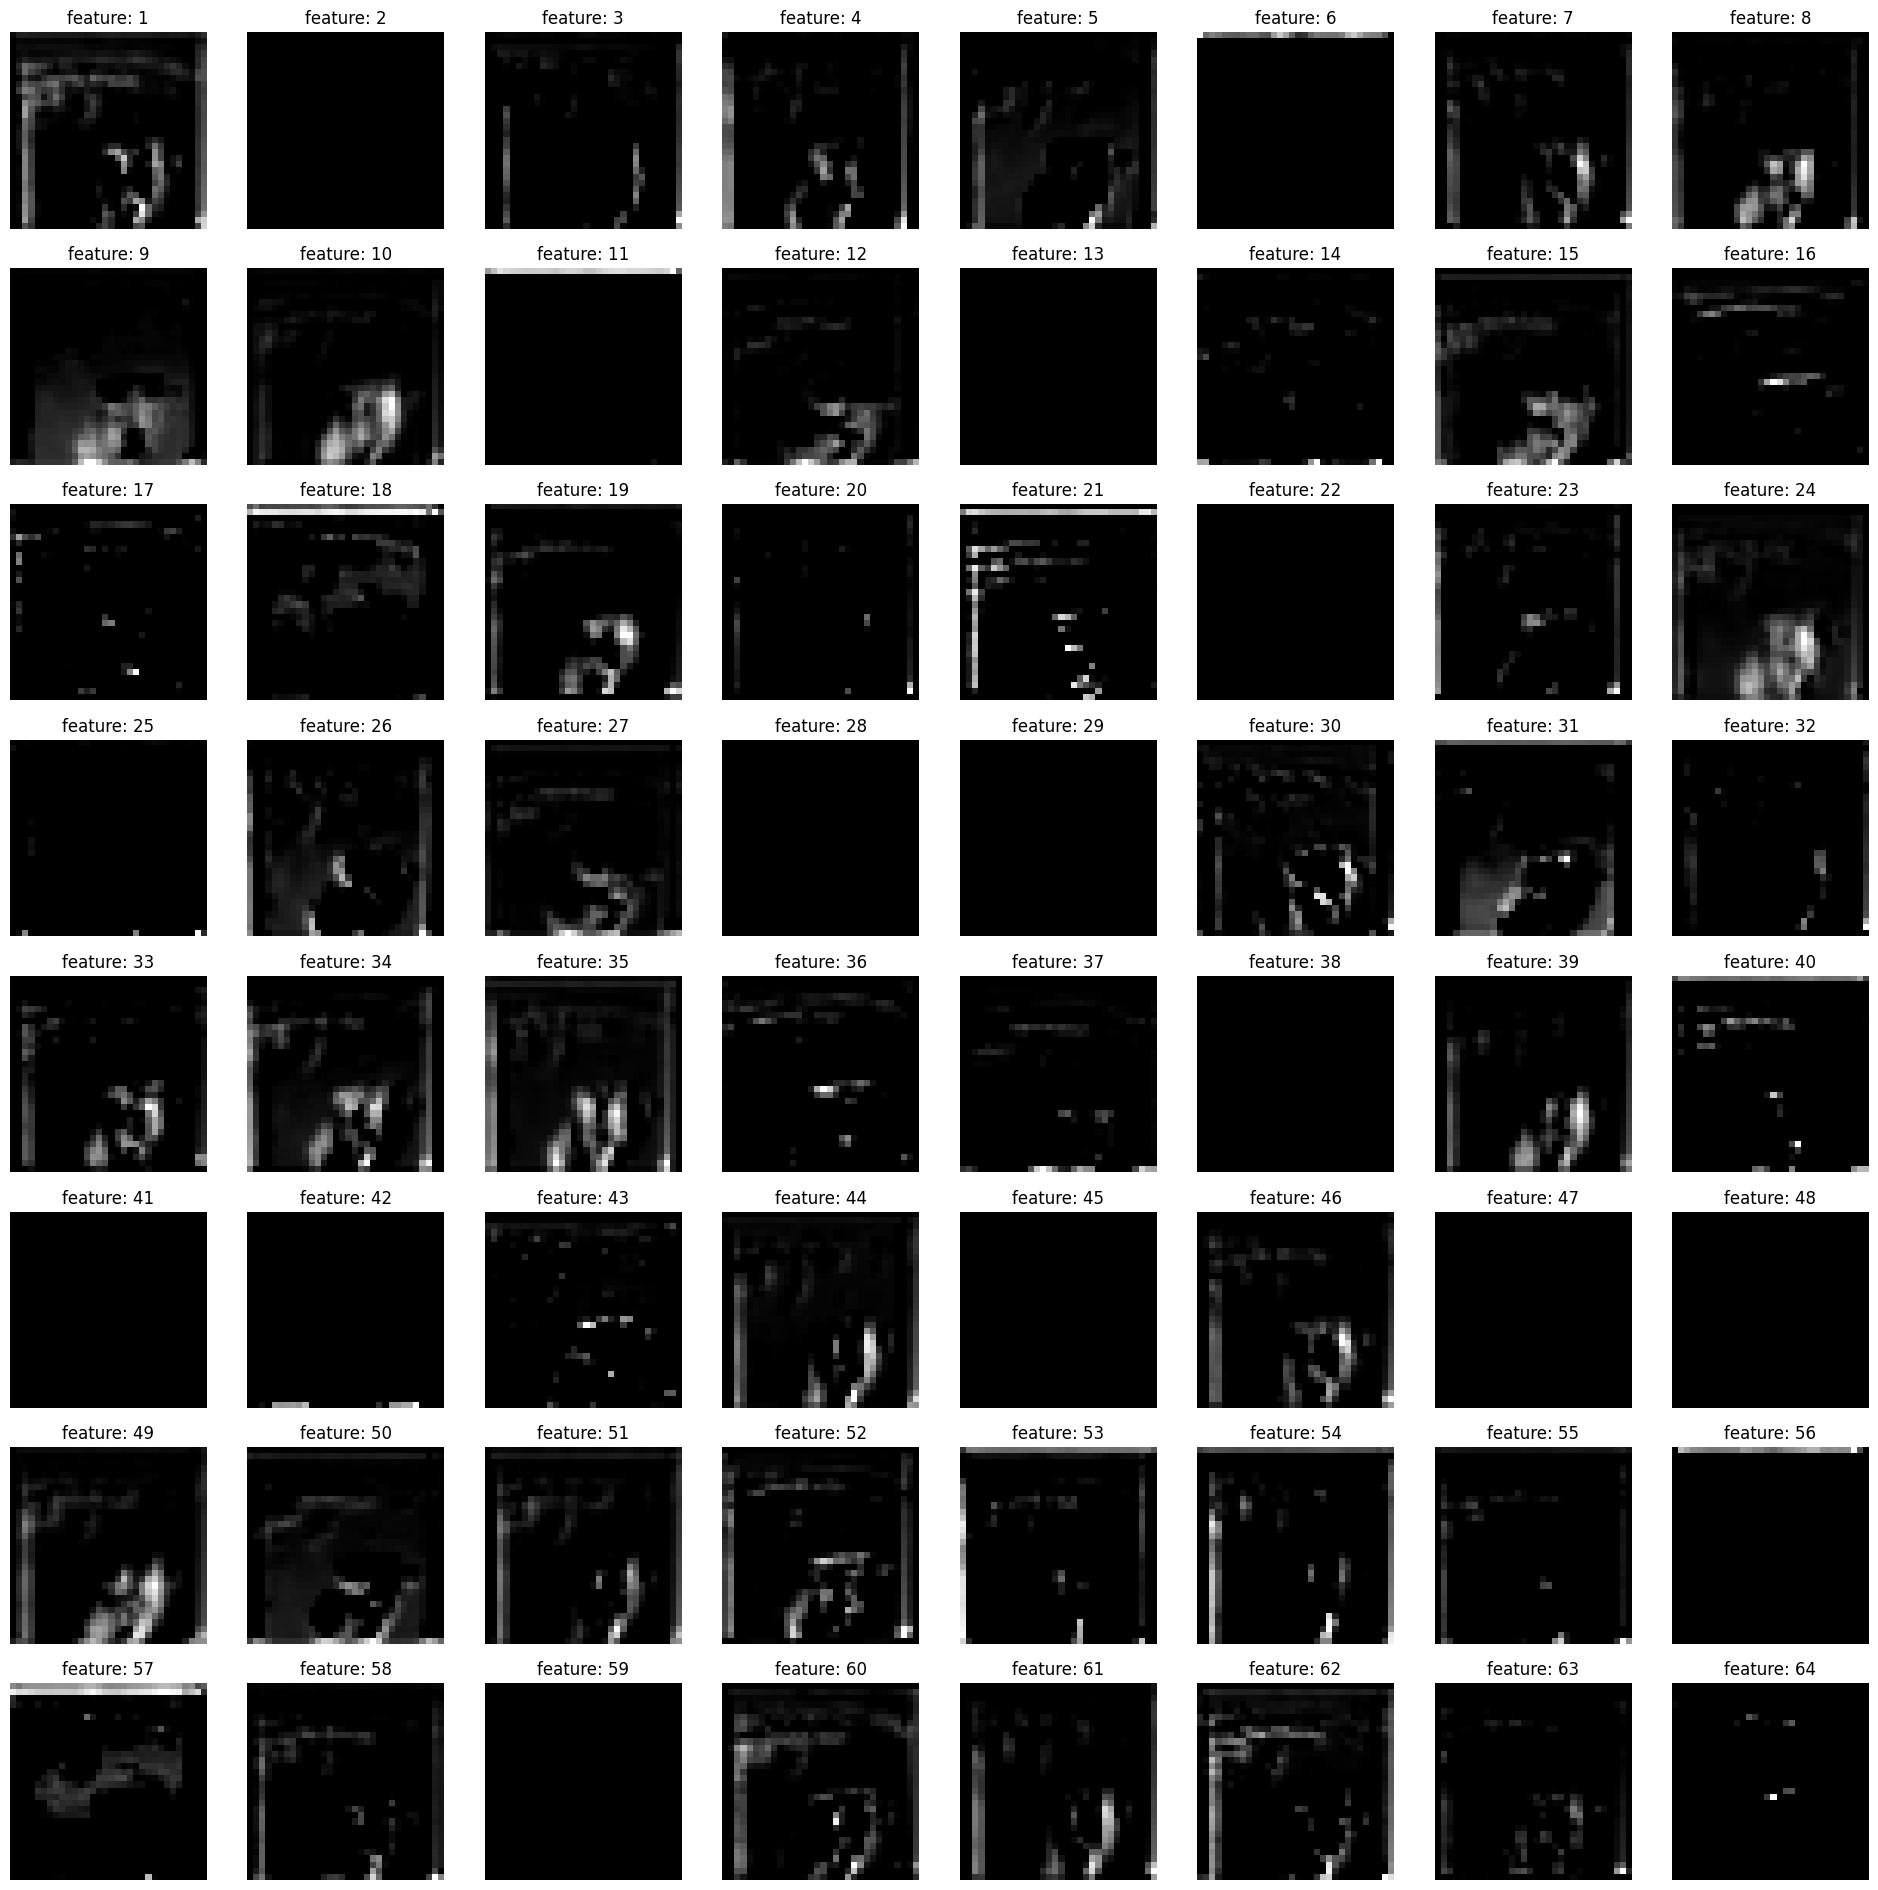

Feature map-7 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x79ea42502f50> output: (1, 32, 32, 64)


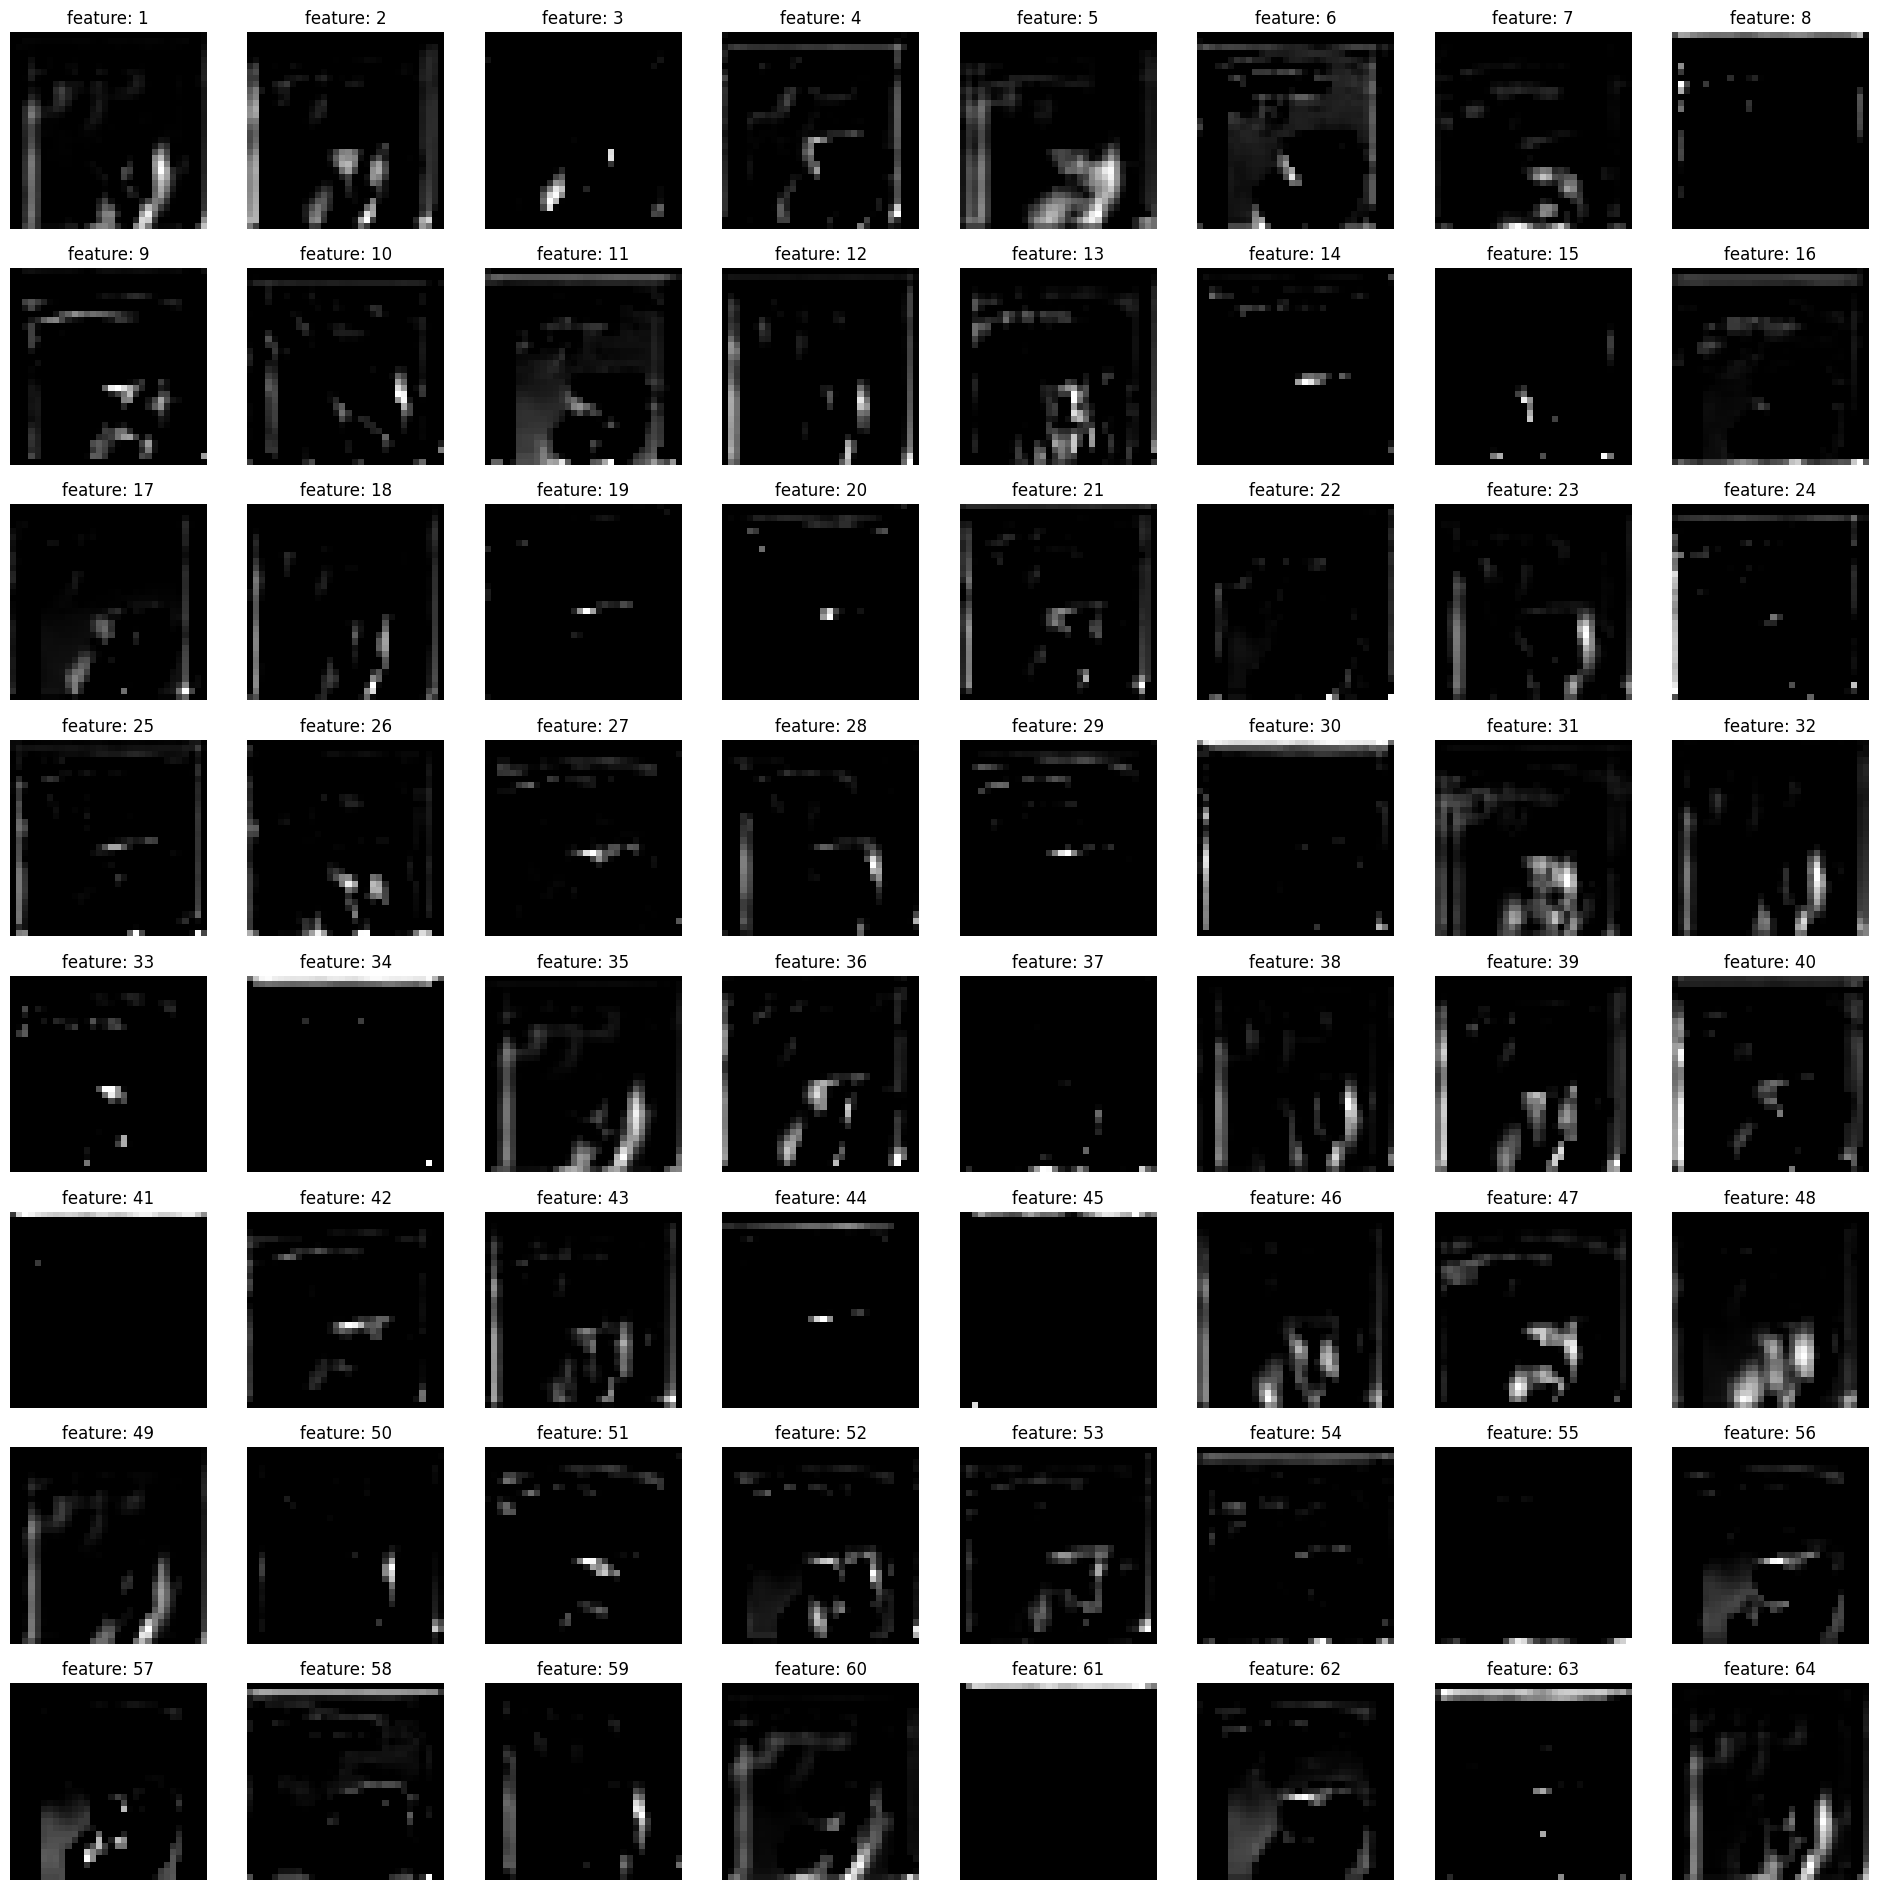

Feature map-8 <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x79ea425034f0> output: (1, 16, 16, 128)


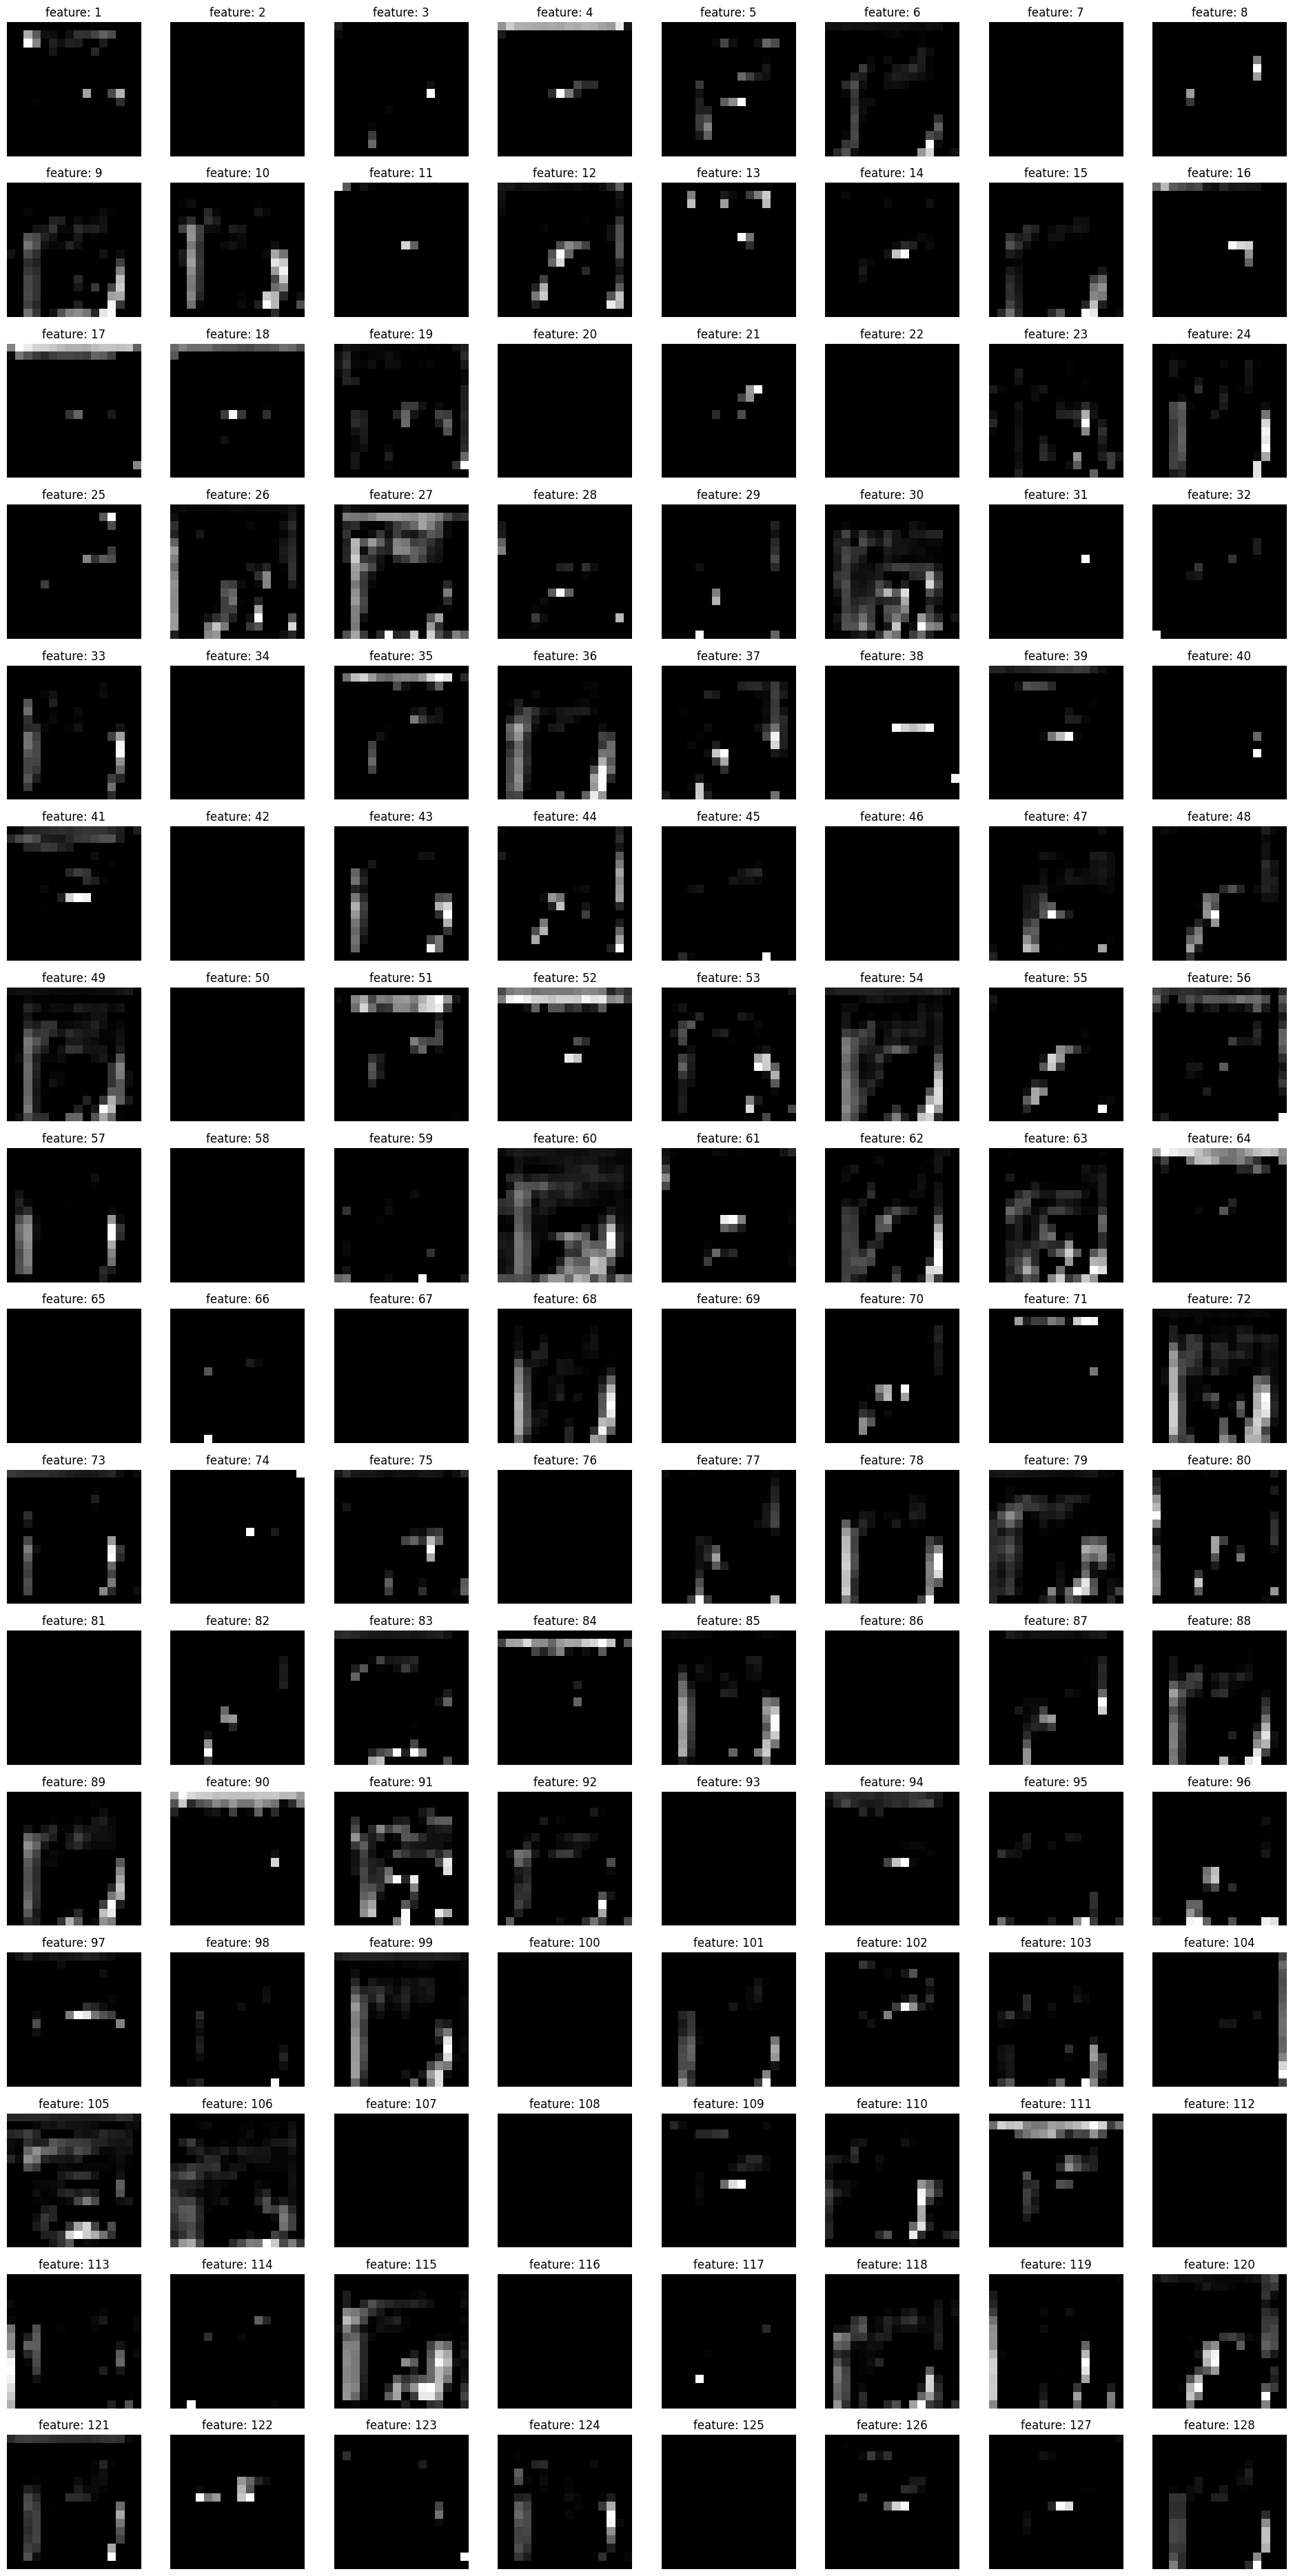

Feature map-9 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x79ea42503850> output: (1, 16, 16, 128)


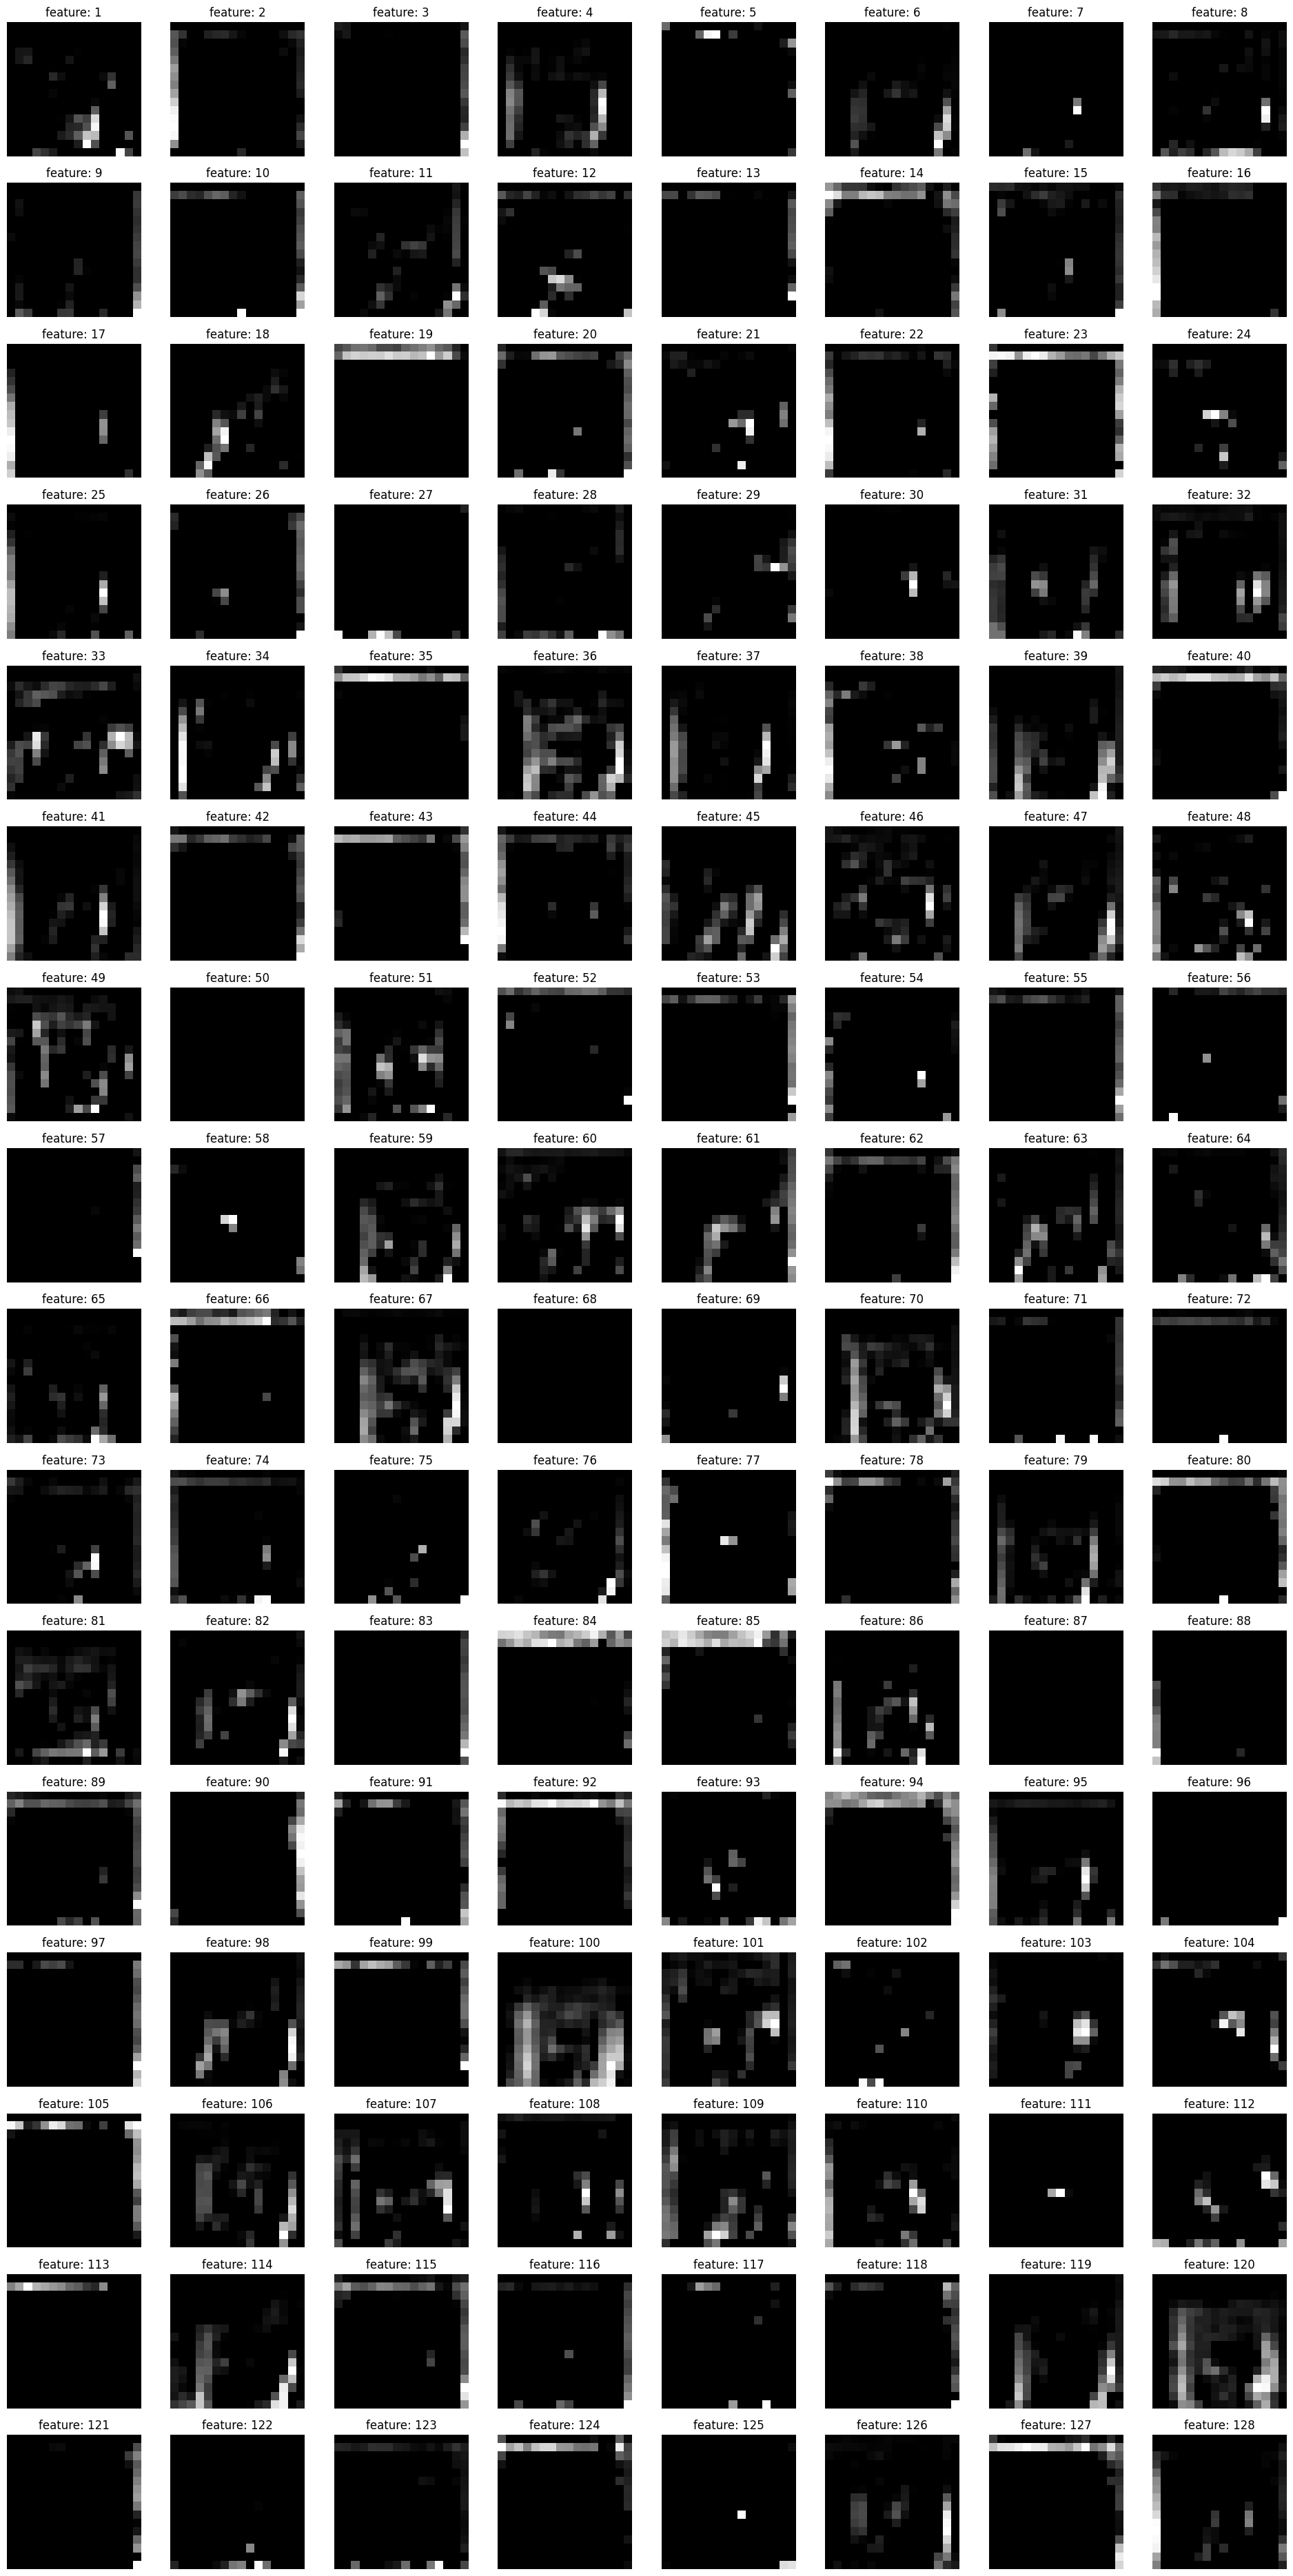

Feature map-10 <keras.src.layers.regularization.dropout.Dropout object at 0x79ea42503df0> output: (1, 32, 32, 64)


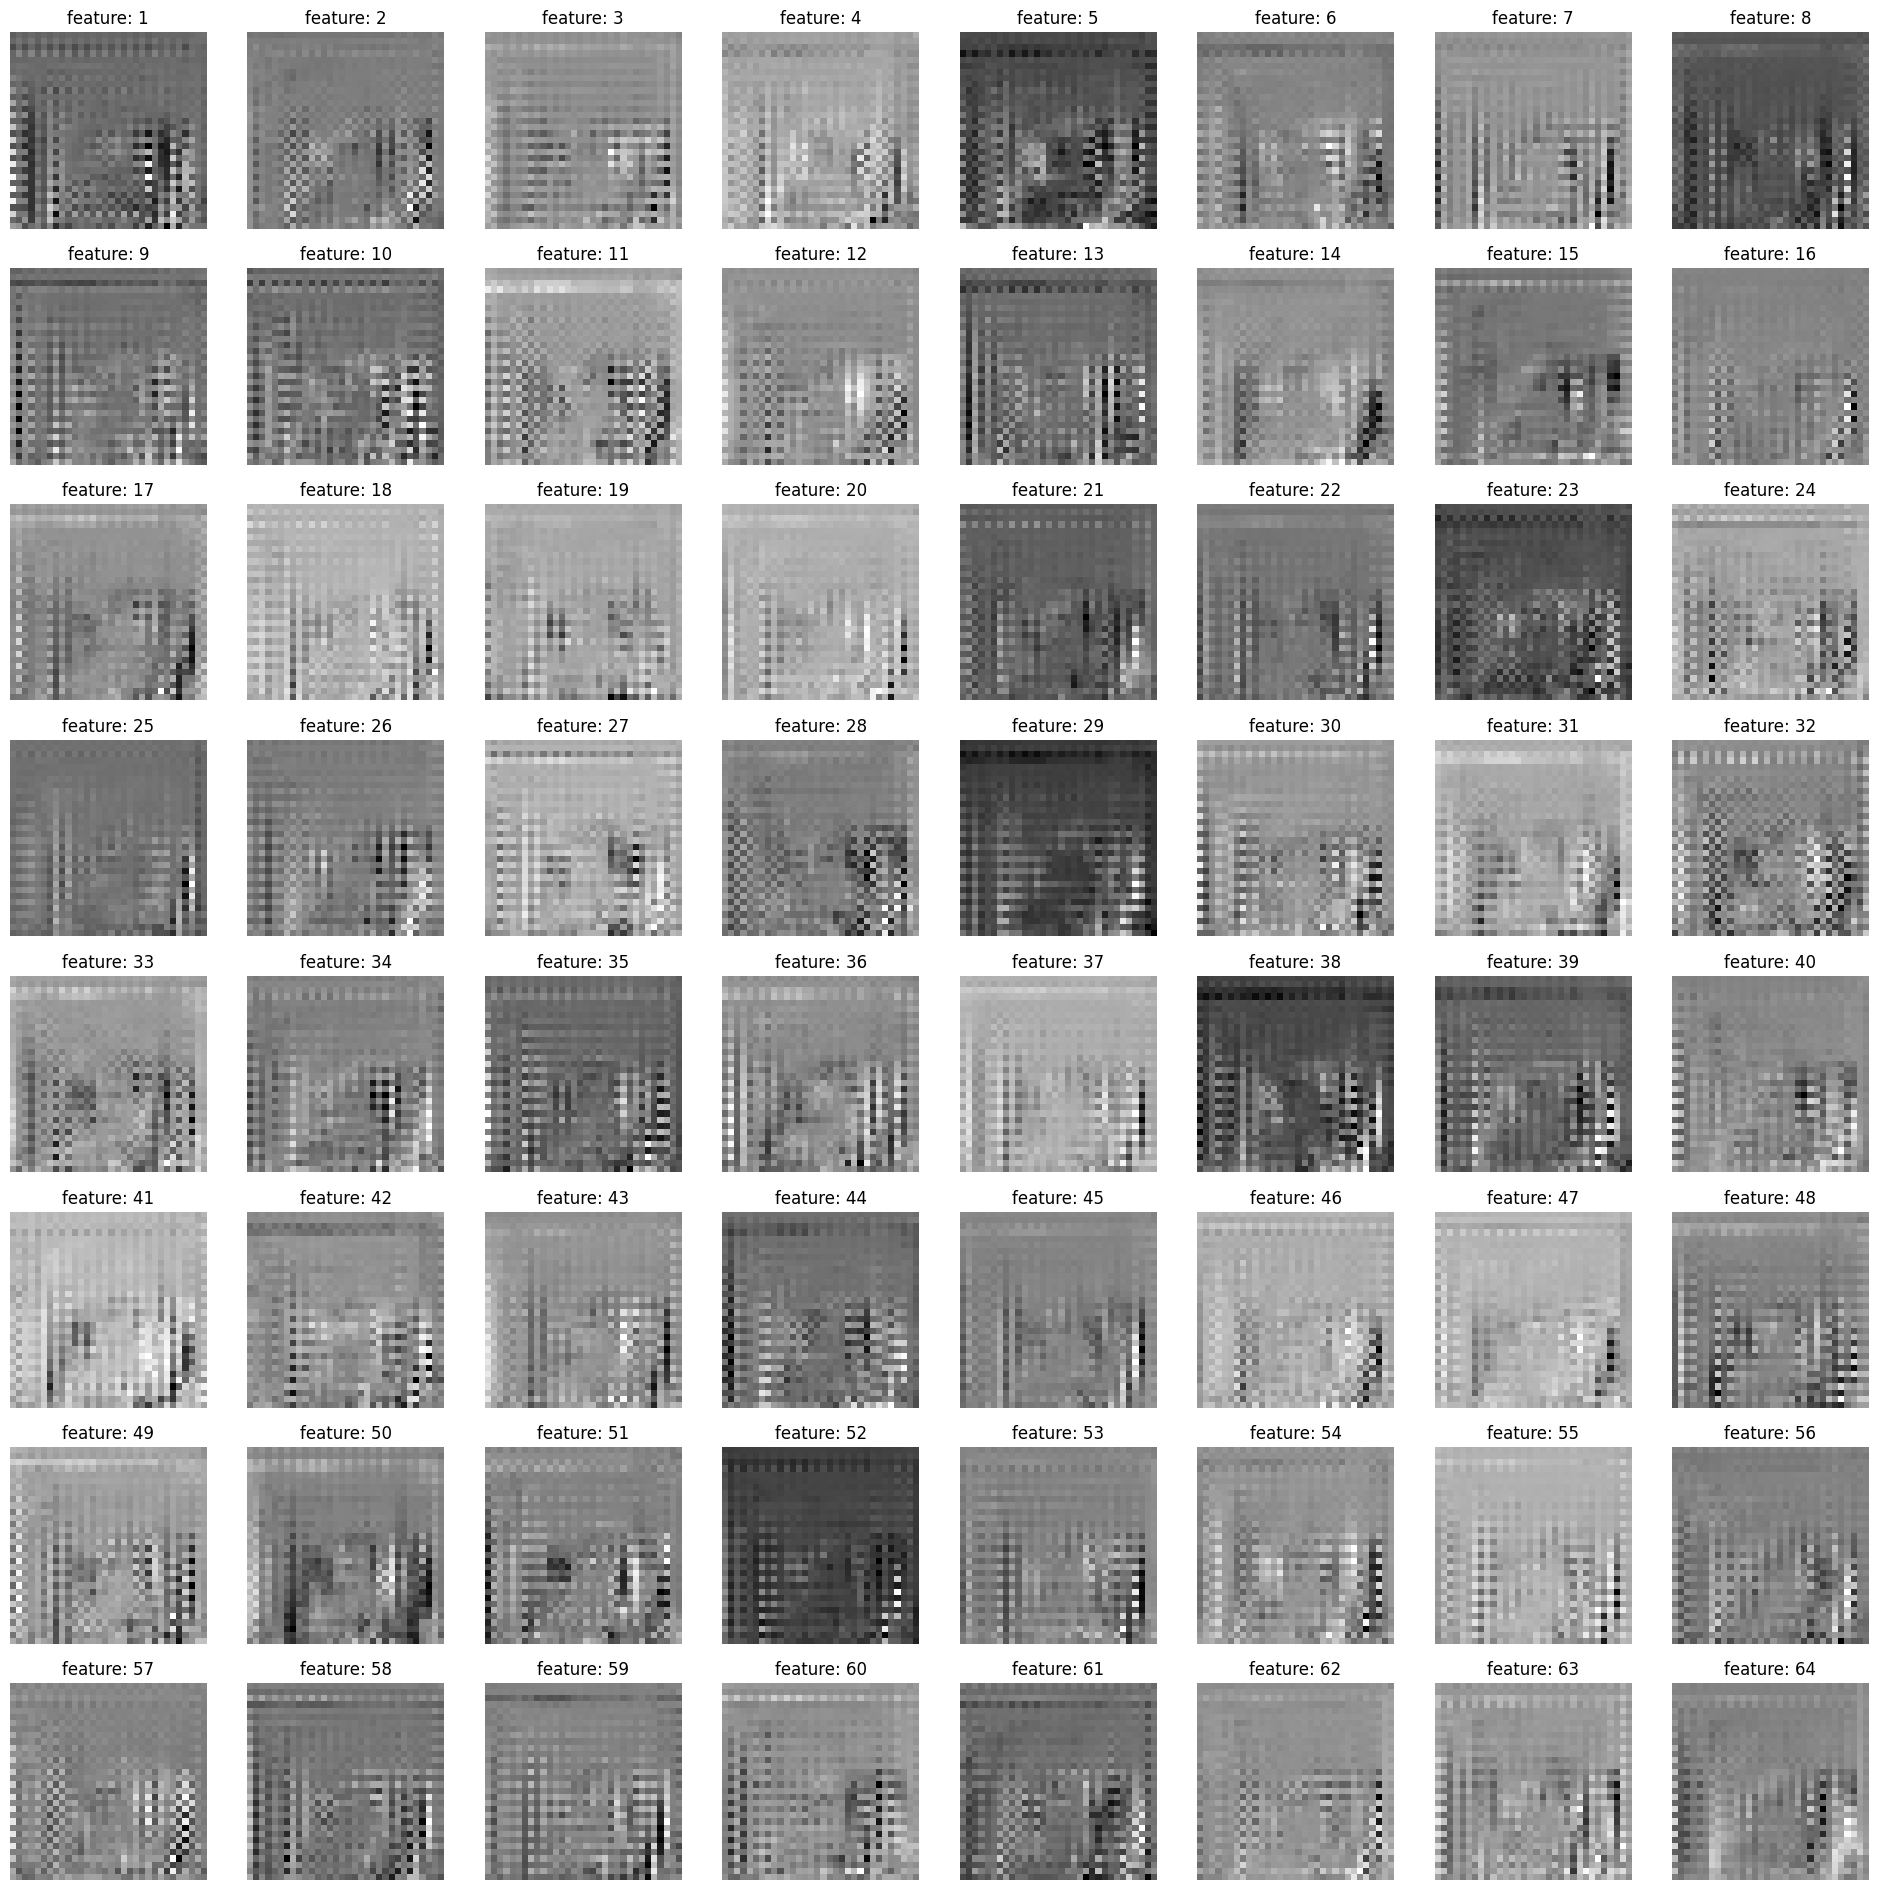

Feature map-11 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x79ea4044fa30> output: (1, 32, 32, 64)


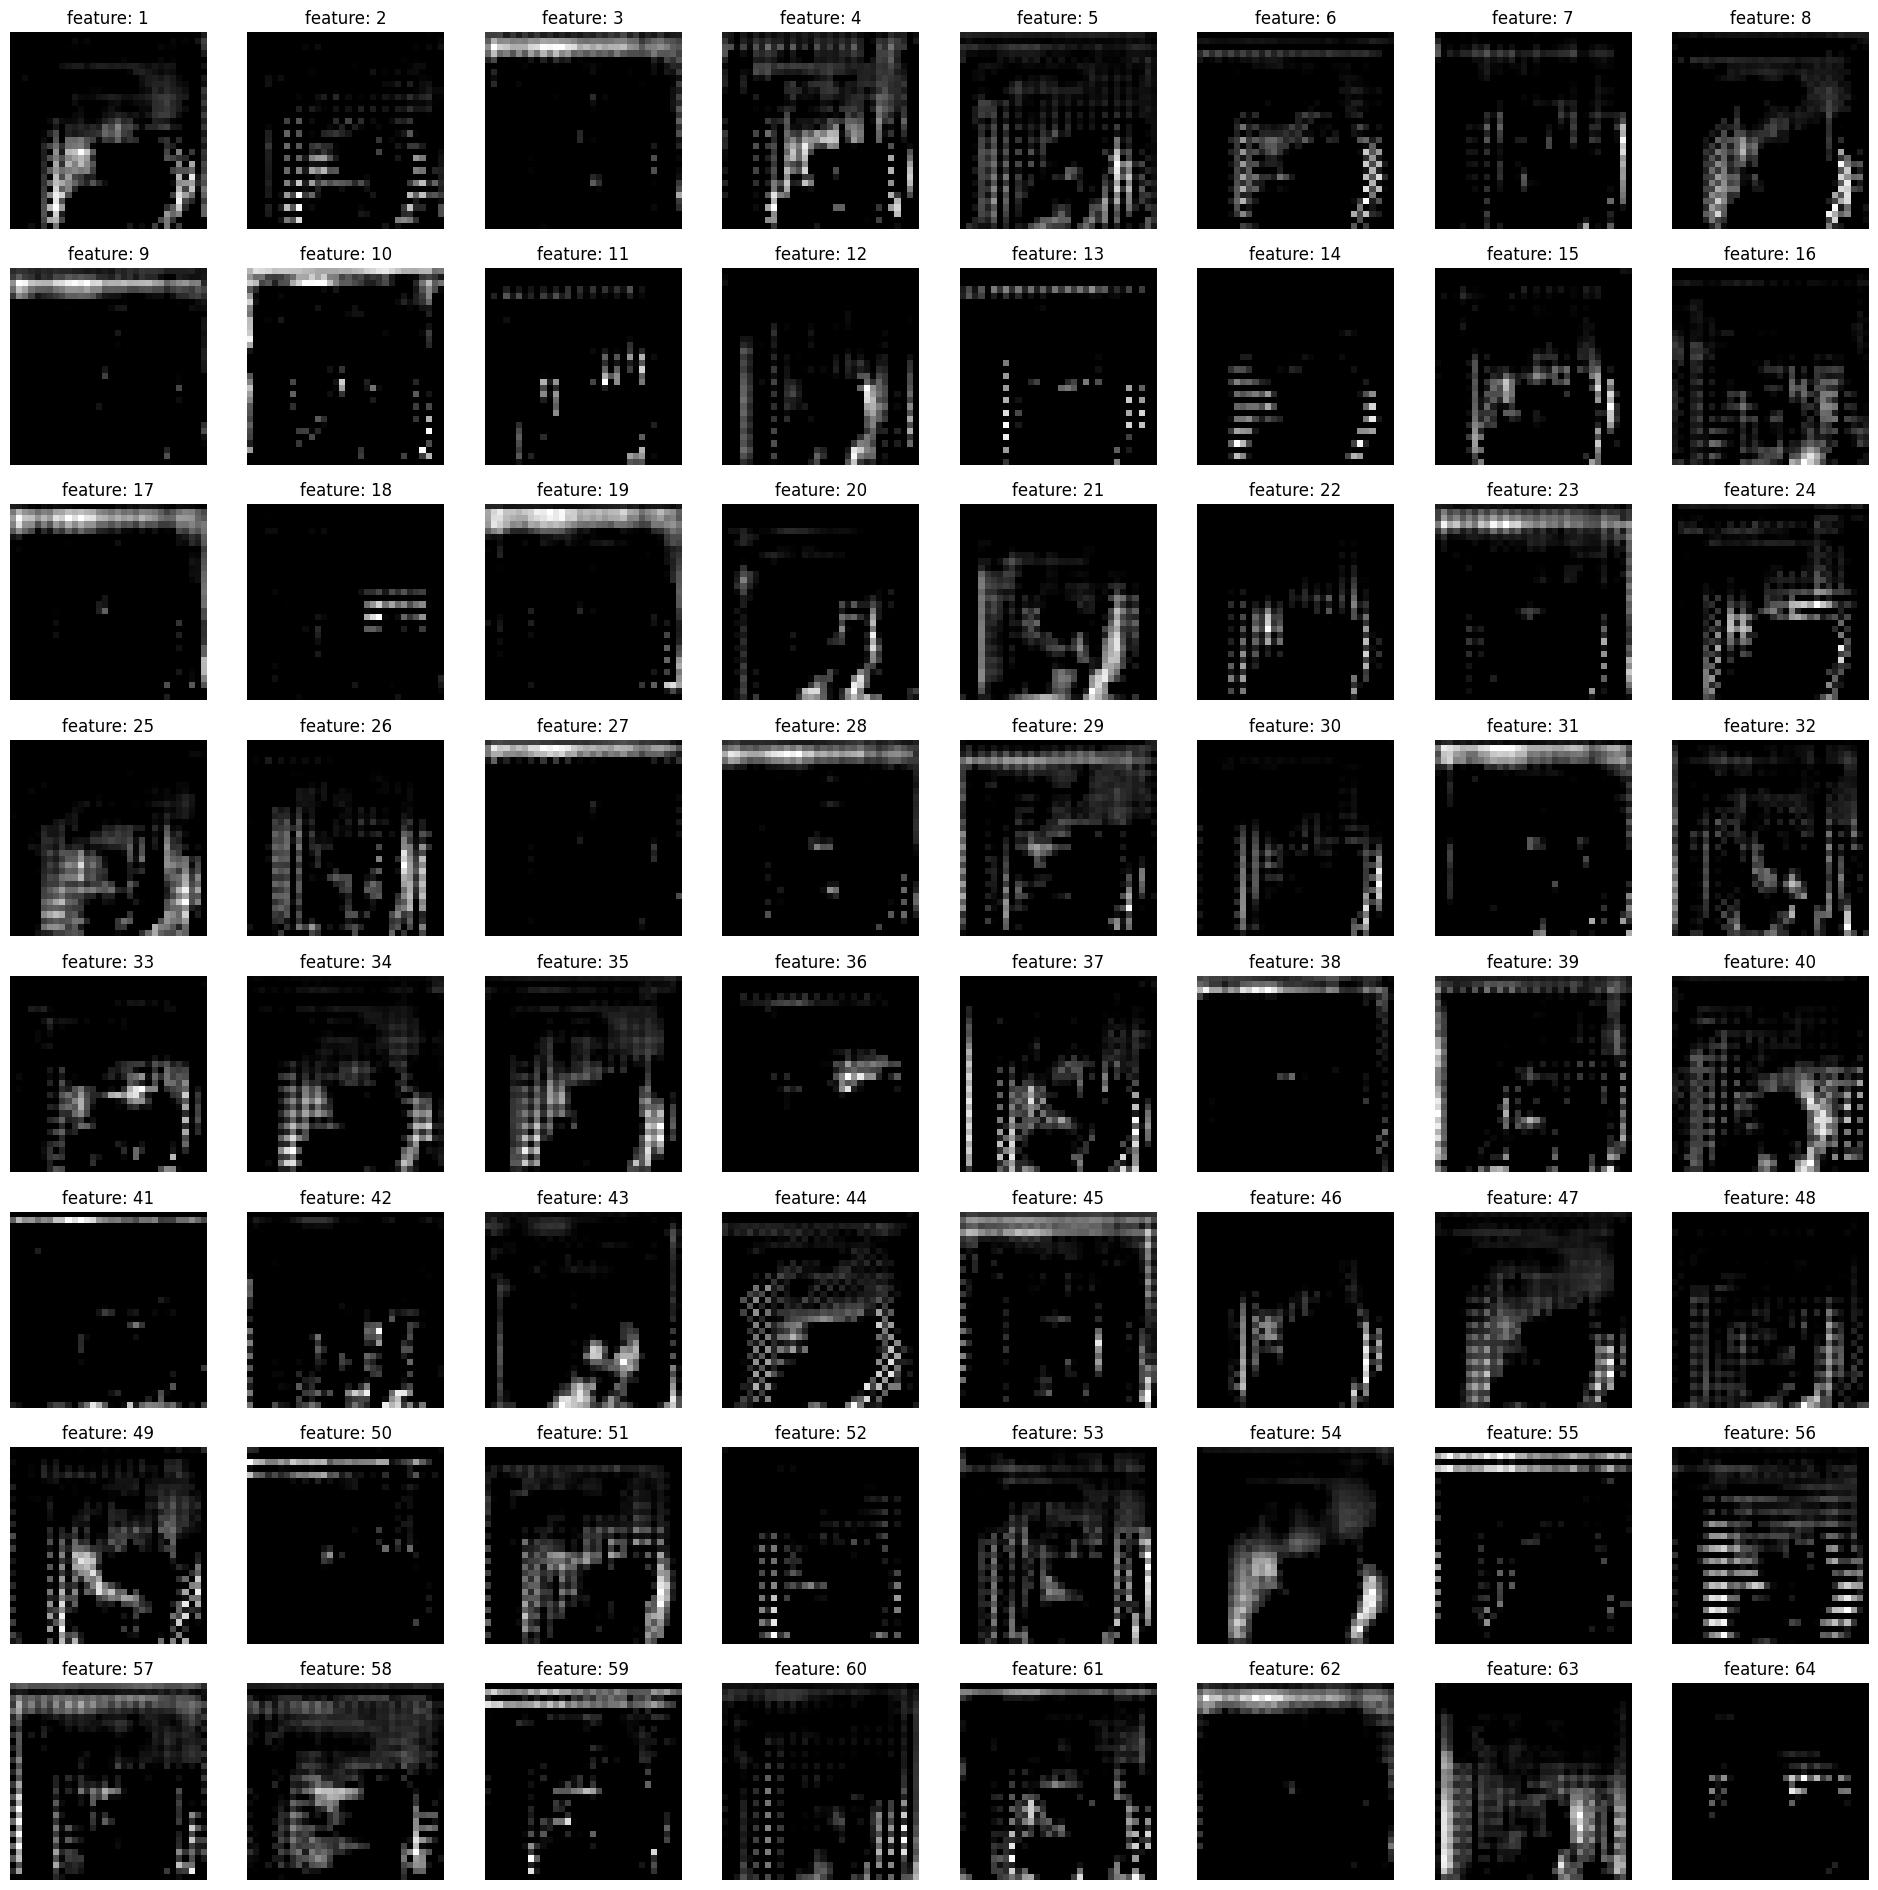

Feature map-12 <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x79ea425206a0> output: (1, 32, 32, 64)


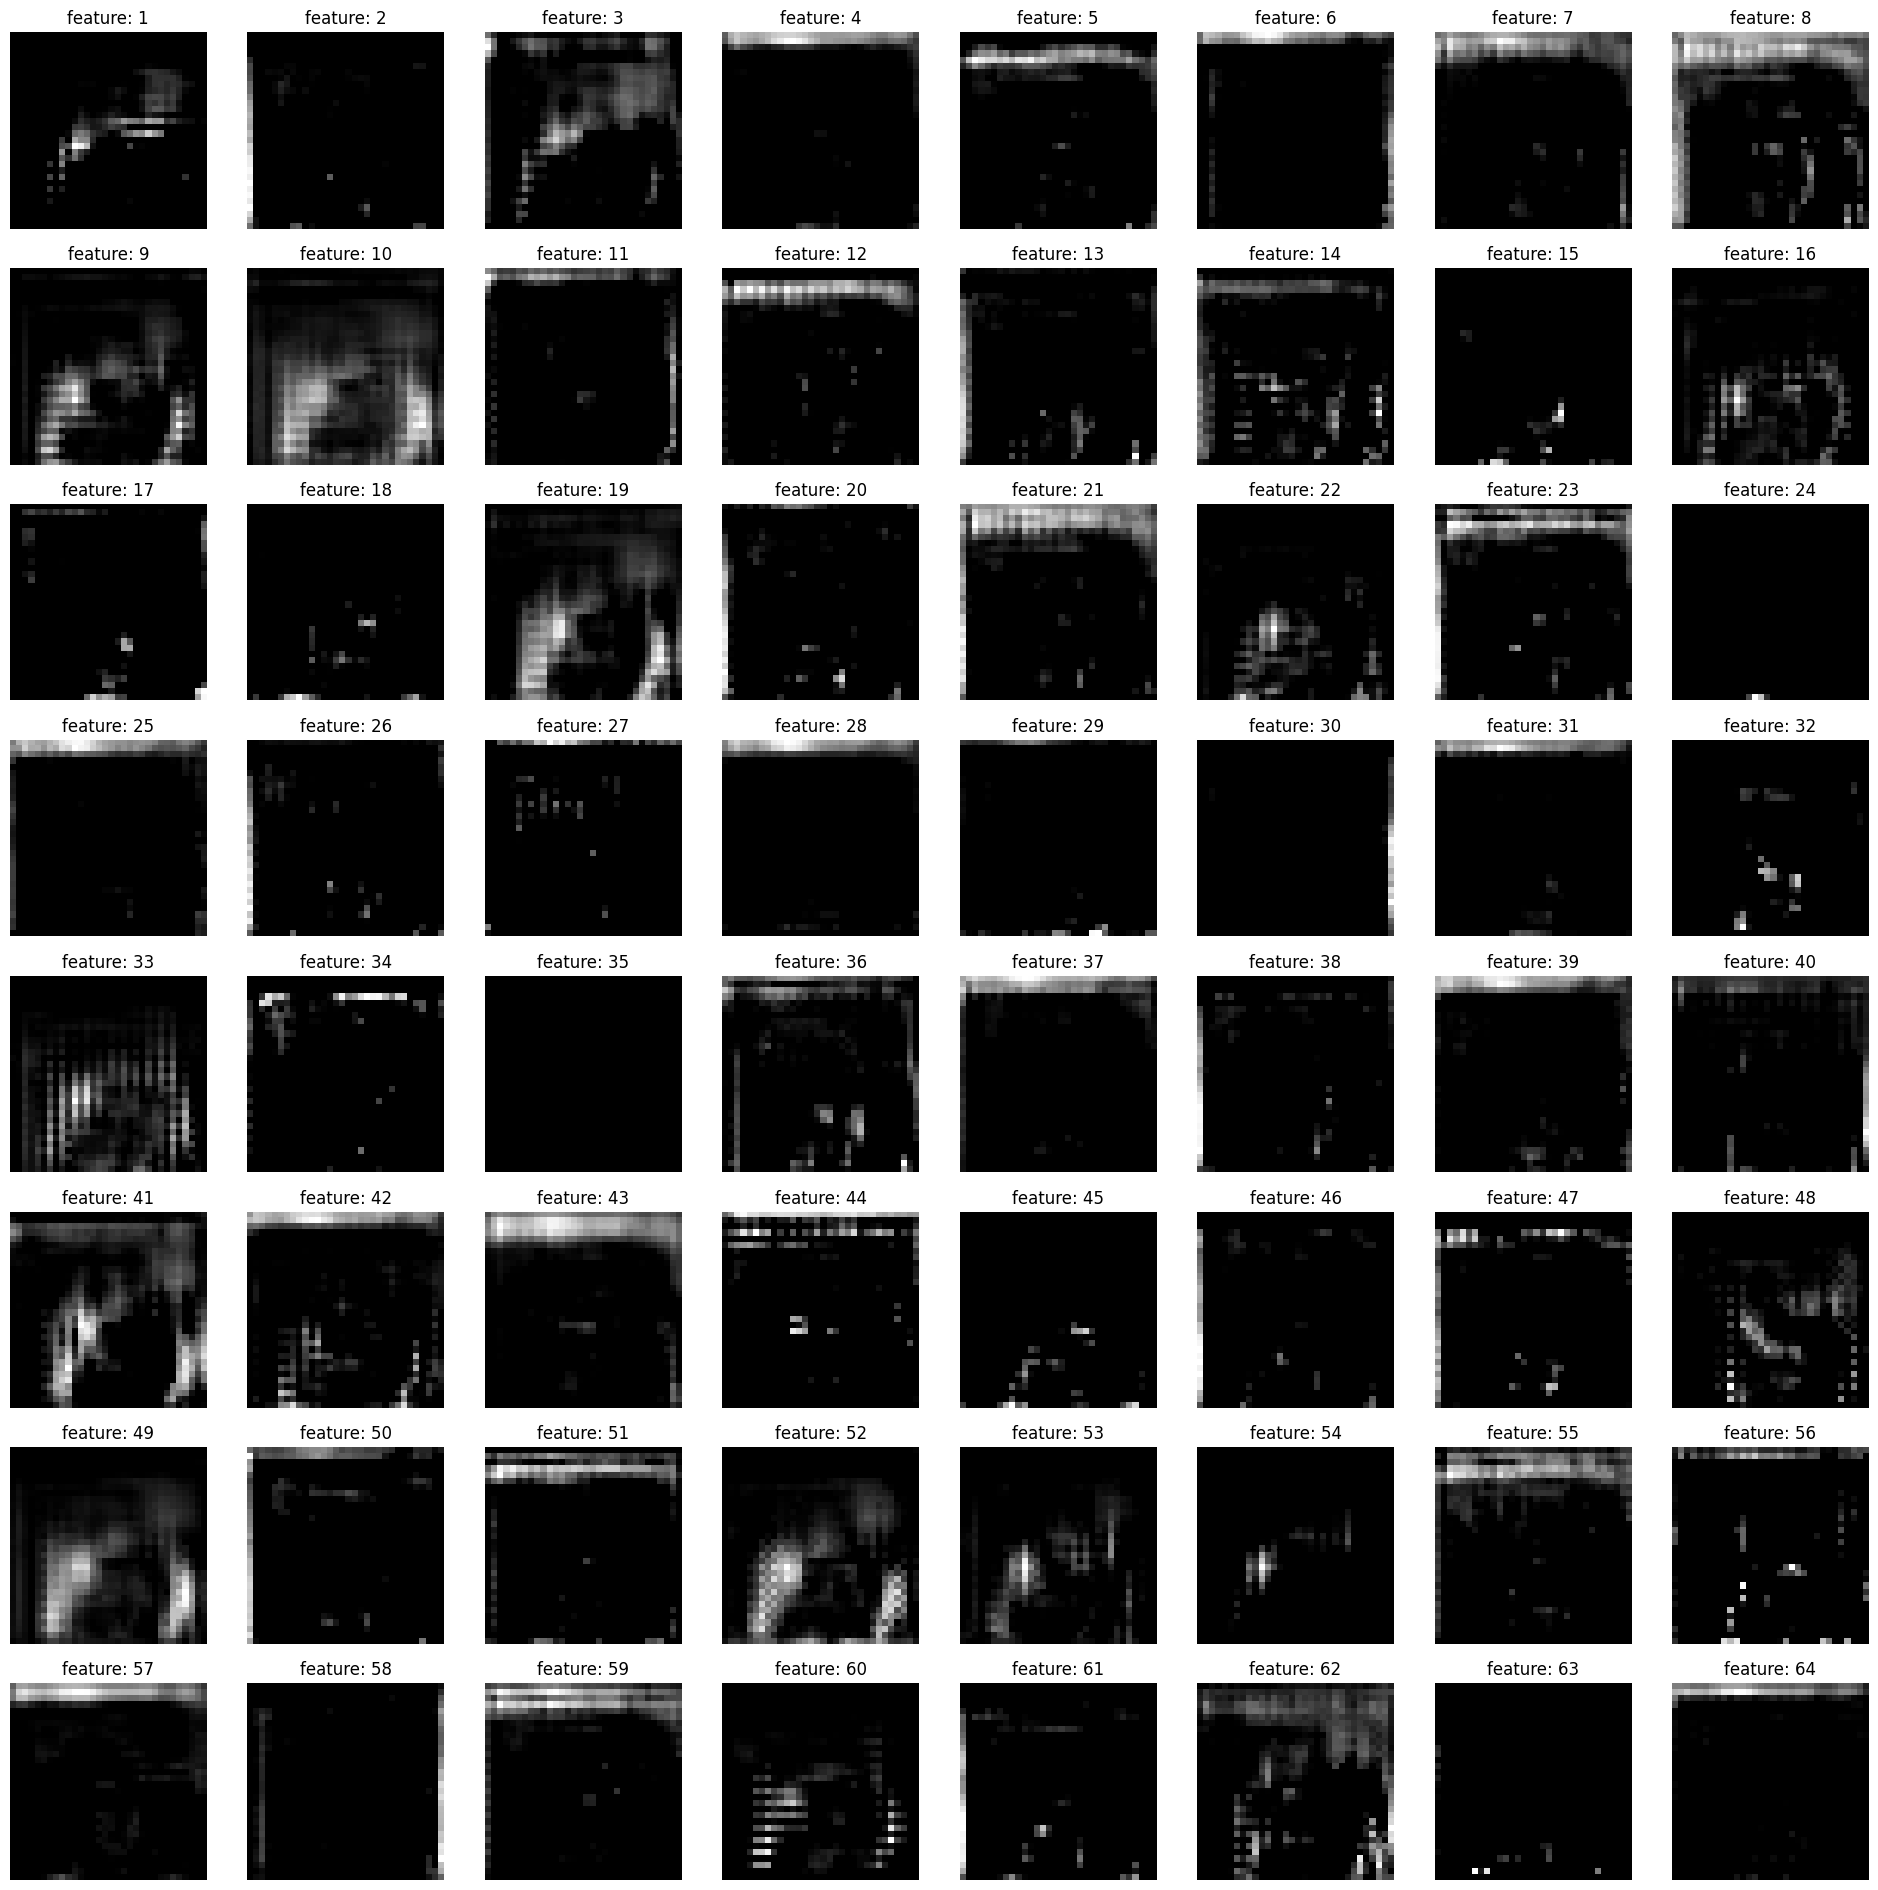

Feature map-13 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x79ea42520a00> output: (1, 64, 64, 32)


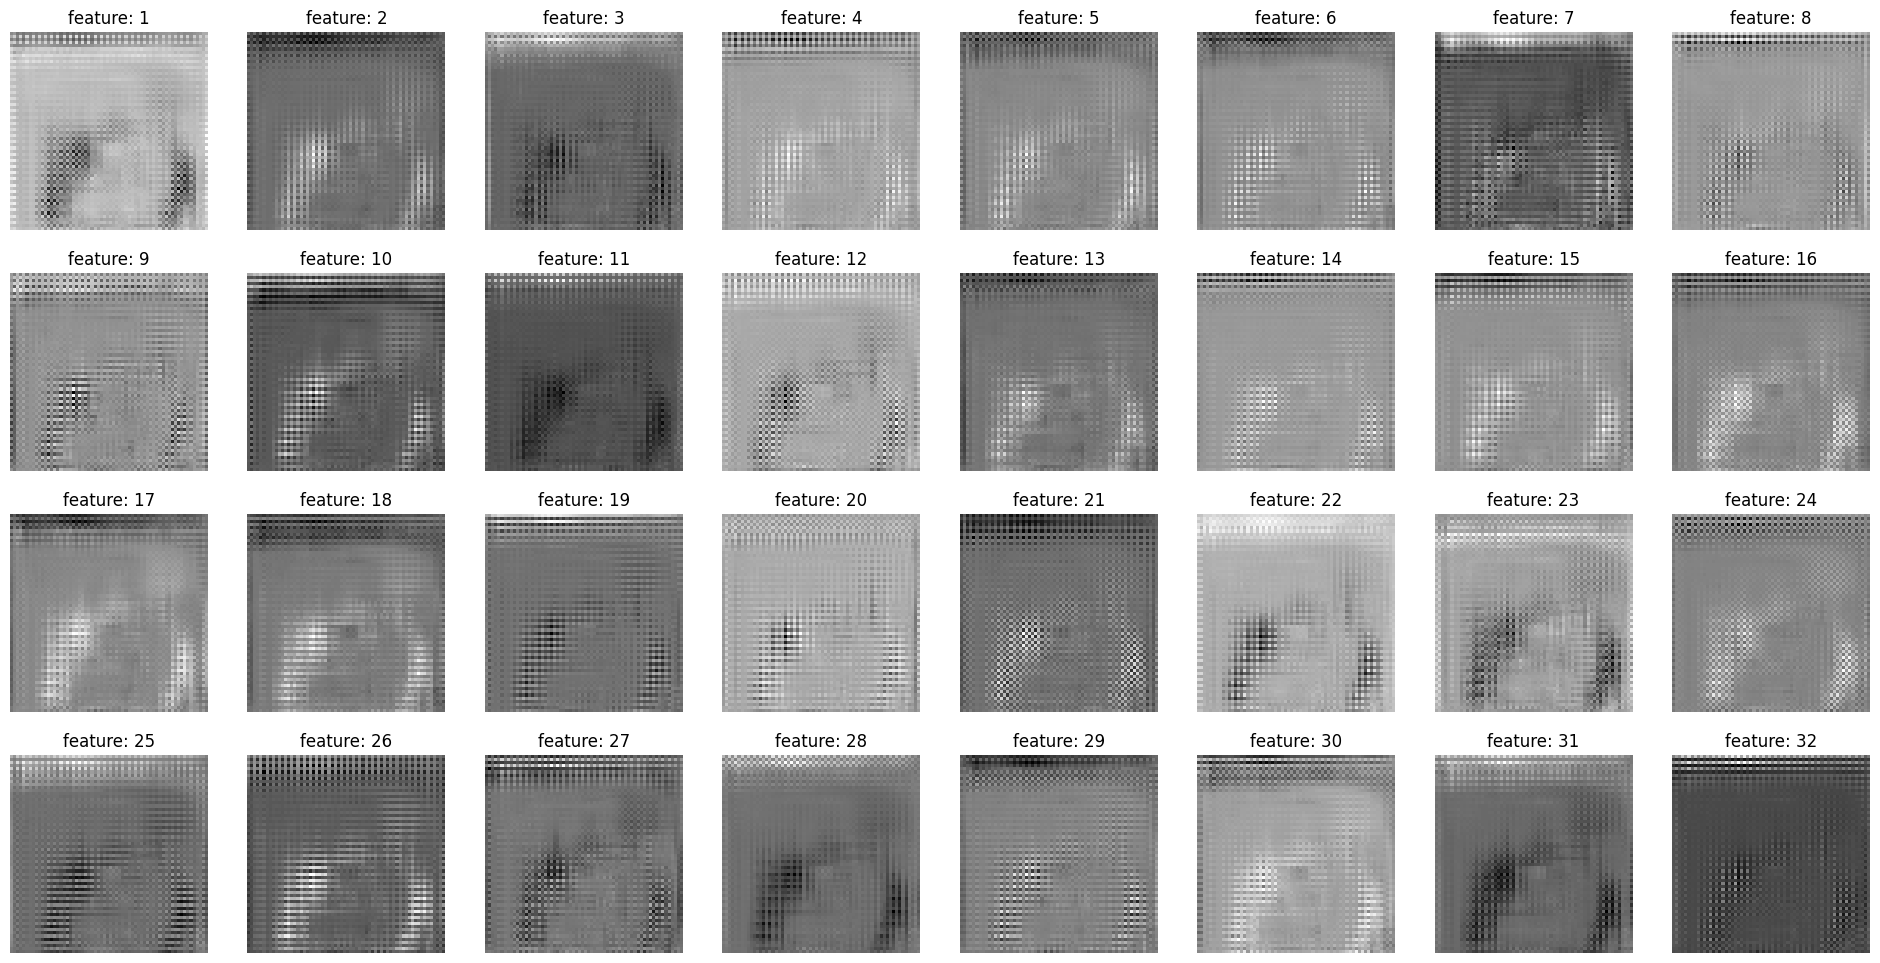

Feature map-14 <keras.src.layers.regularization.dropout.Dropout object at 0x79ea42520fa0> output: (1, 64, 64, 32)


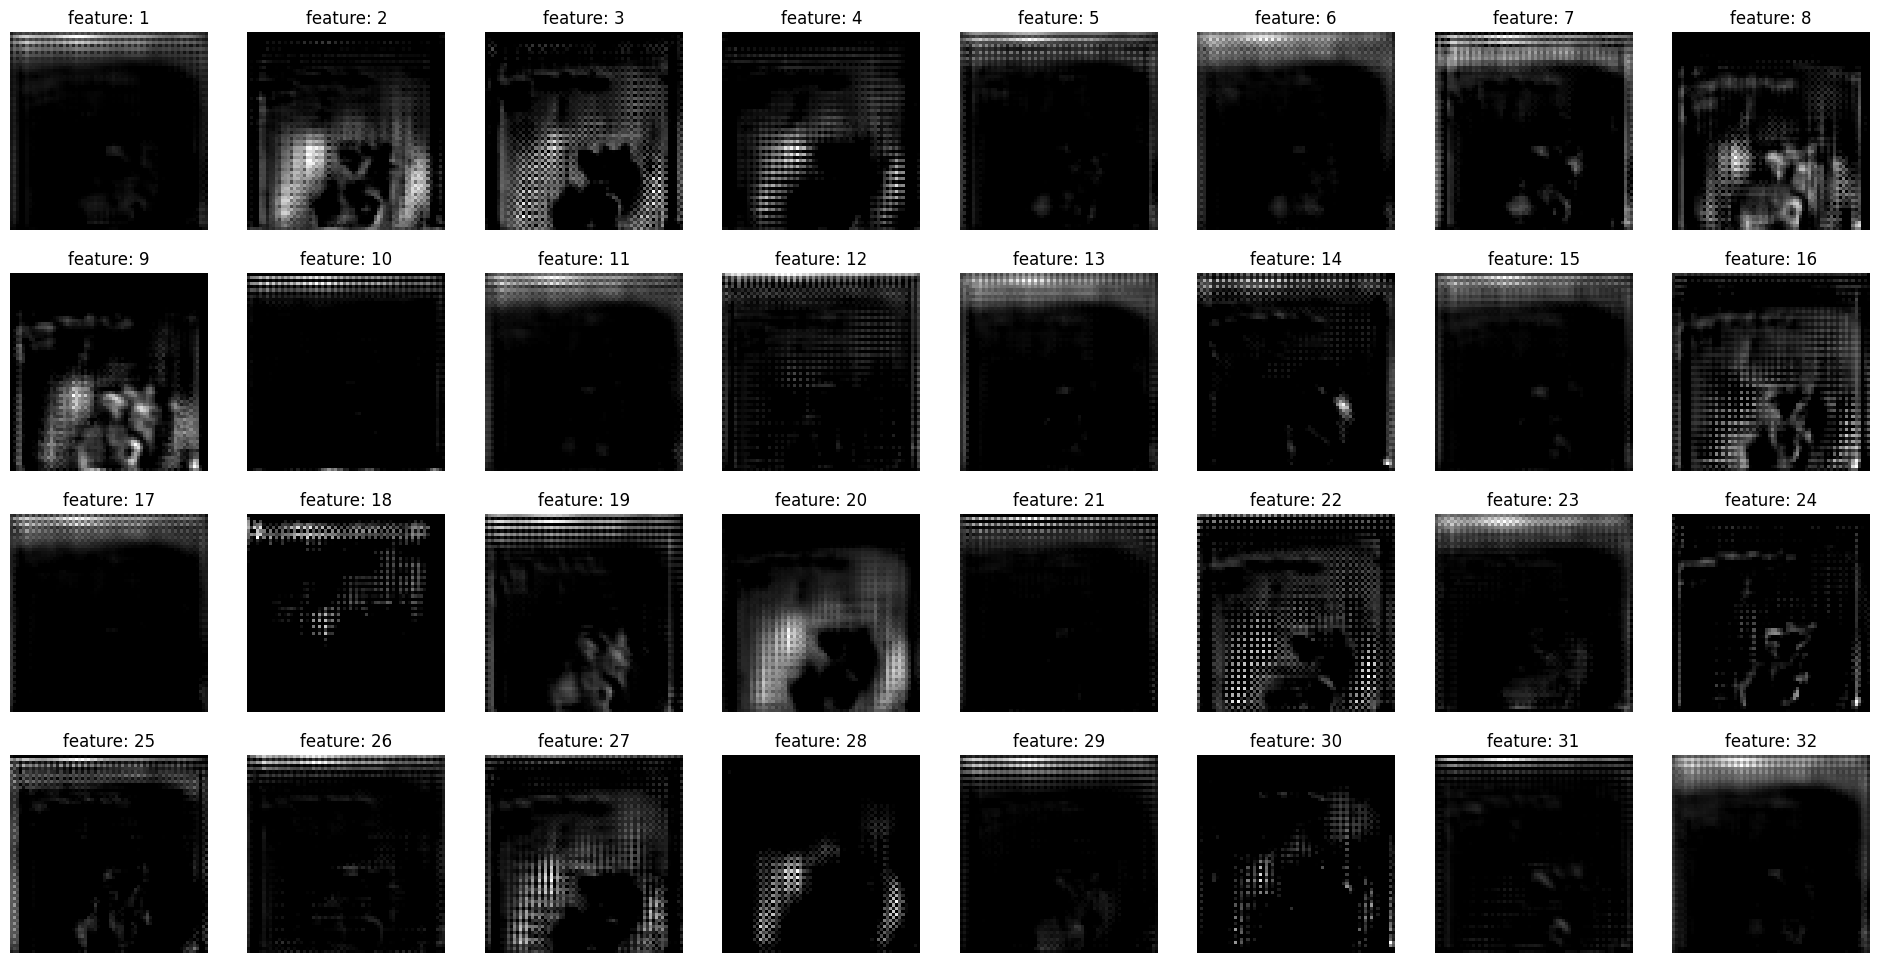

Feature map-15 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x79ea42521270> output: (1, 64, 64, 32)


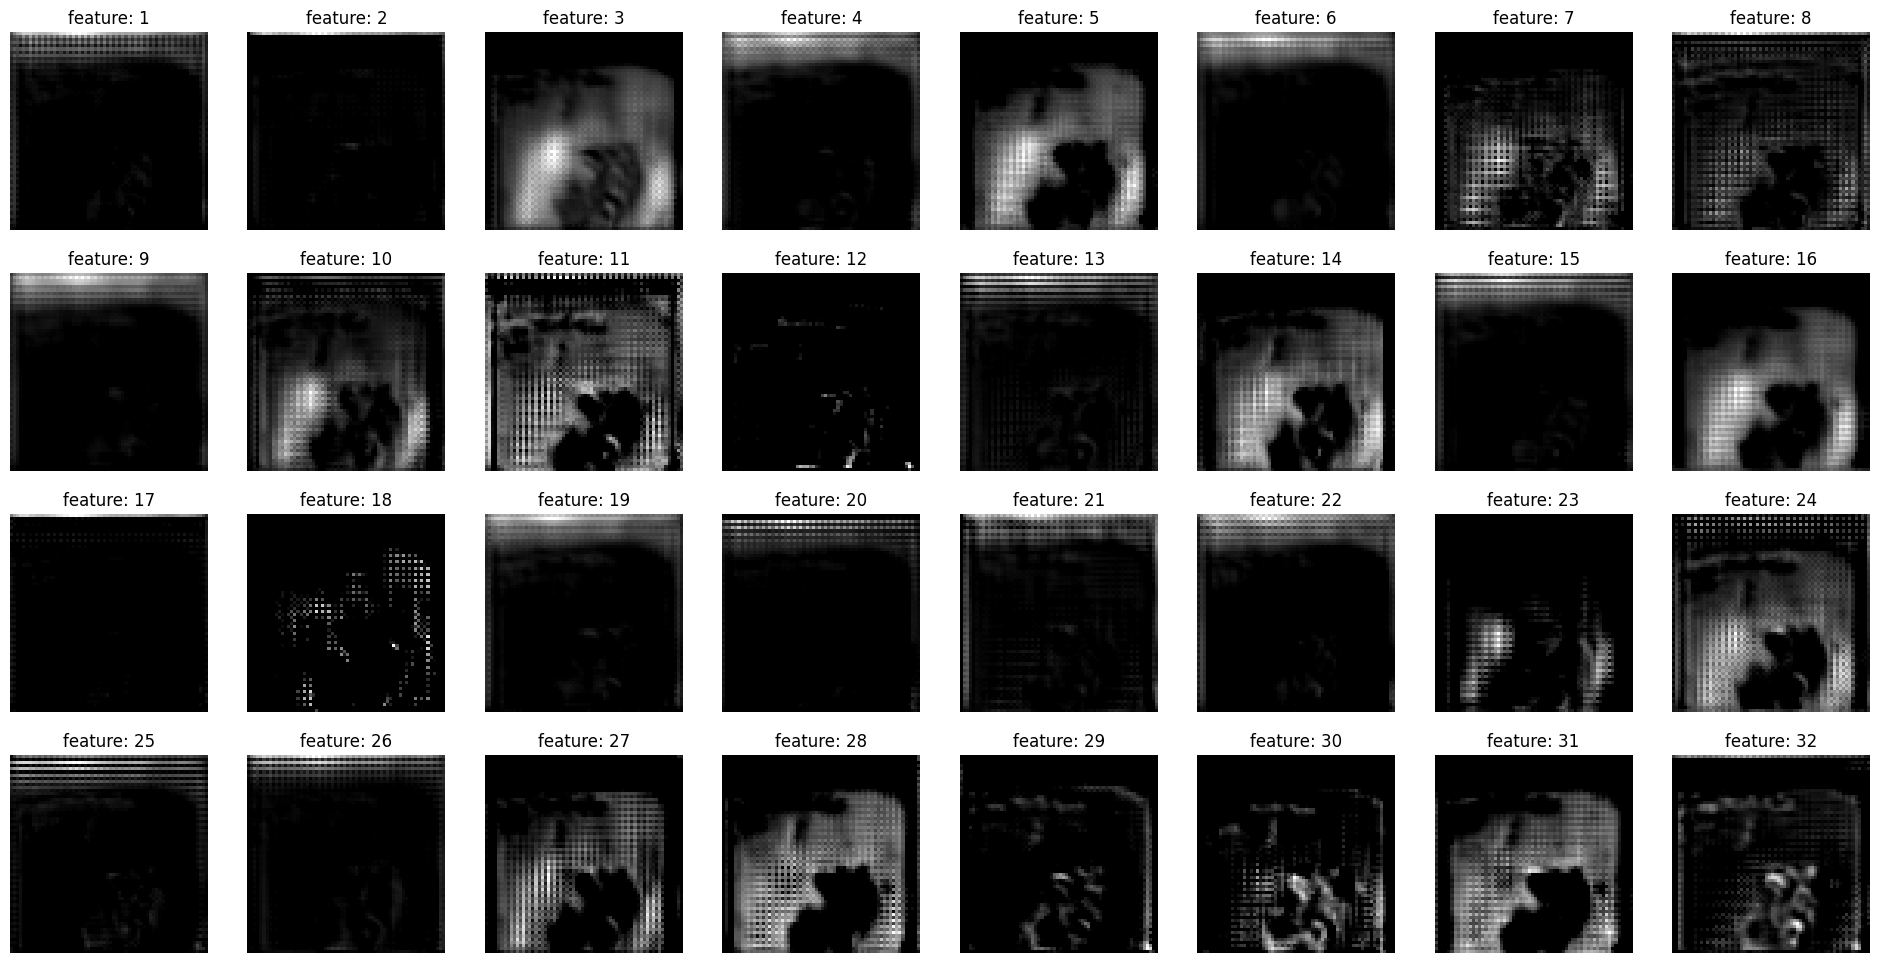

Feature map-16 <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x79ea42521810> output: (1, 128, 128, 16)


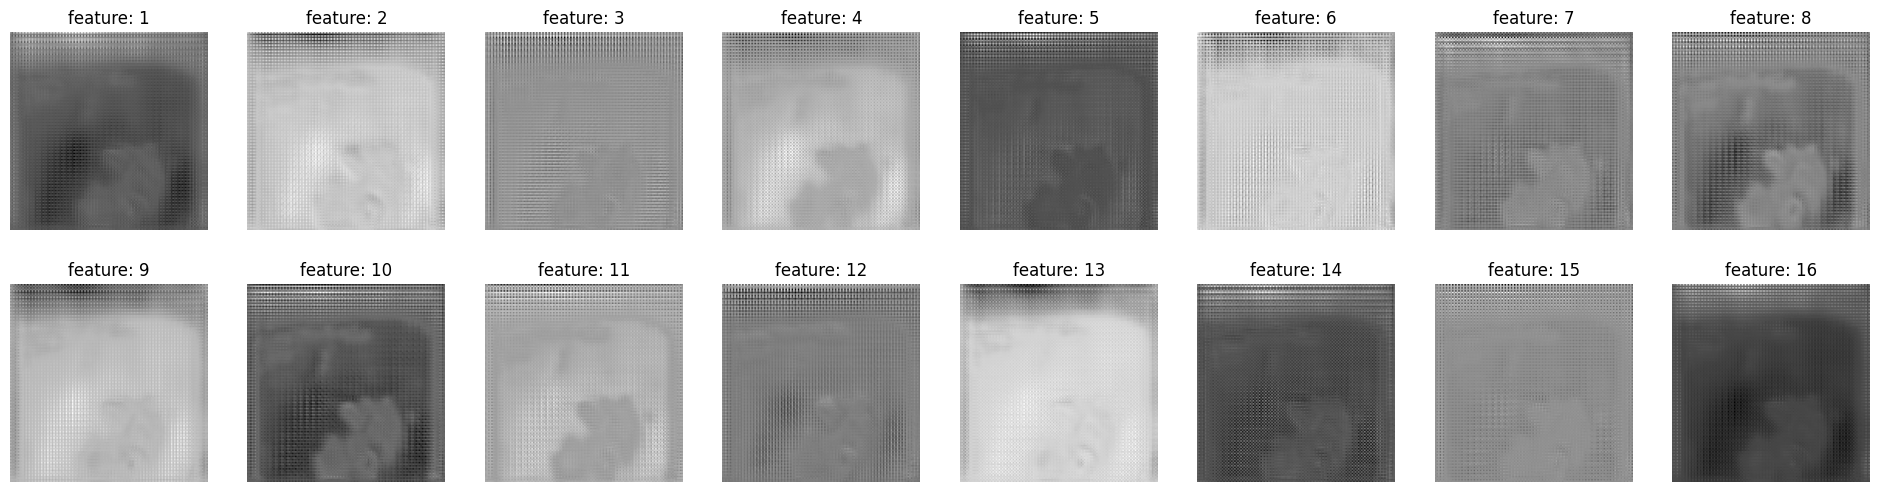

Feature map-17 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x79ea42521b70> output: (1, 128, 128, 16)


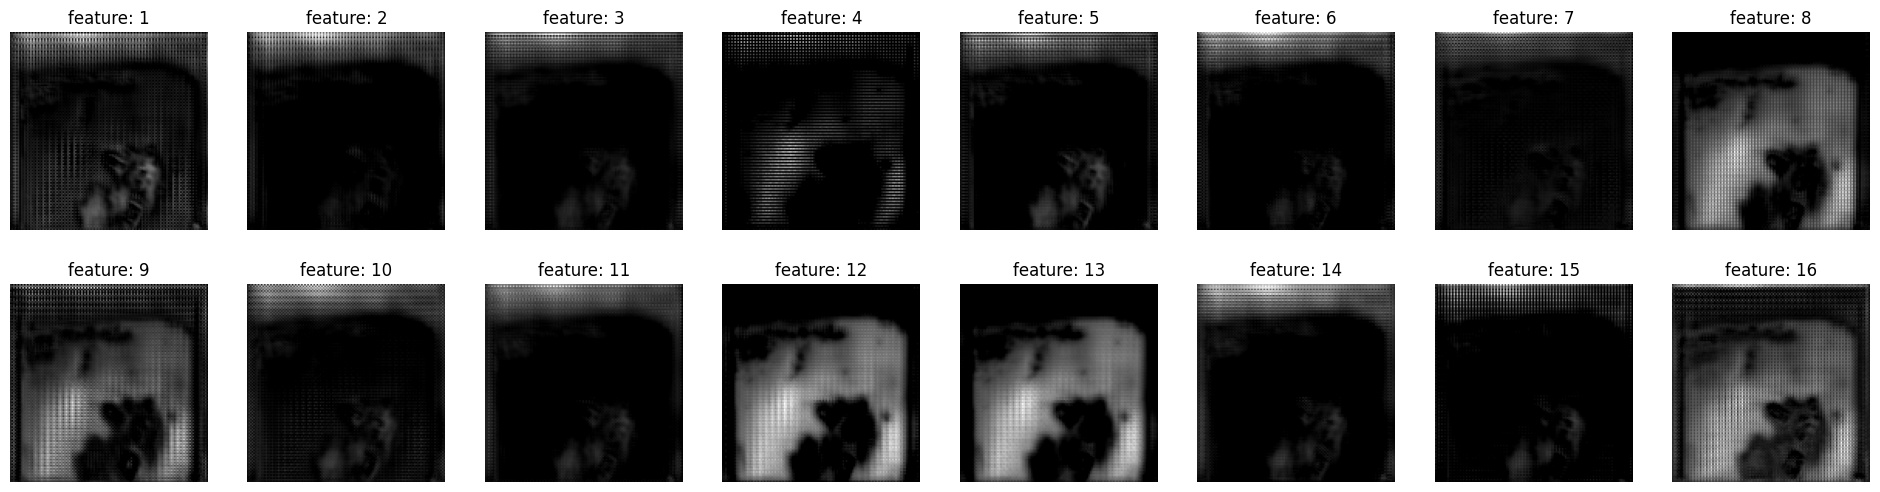

Feature map-18 <keras.src.layers.regularization.dropout.Dropout object at 0x79ea42522110> output: (1, 128, 128, 16)


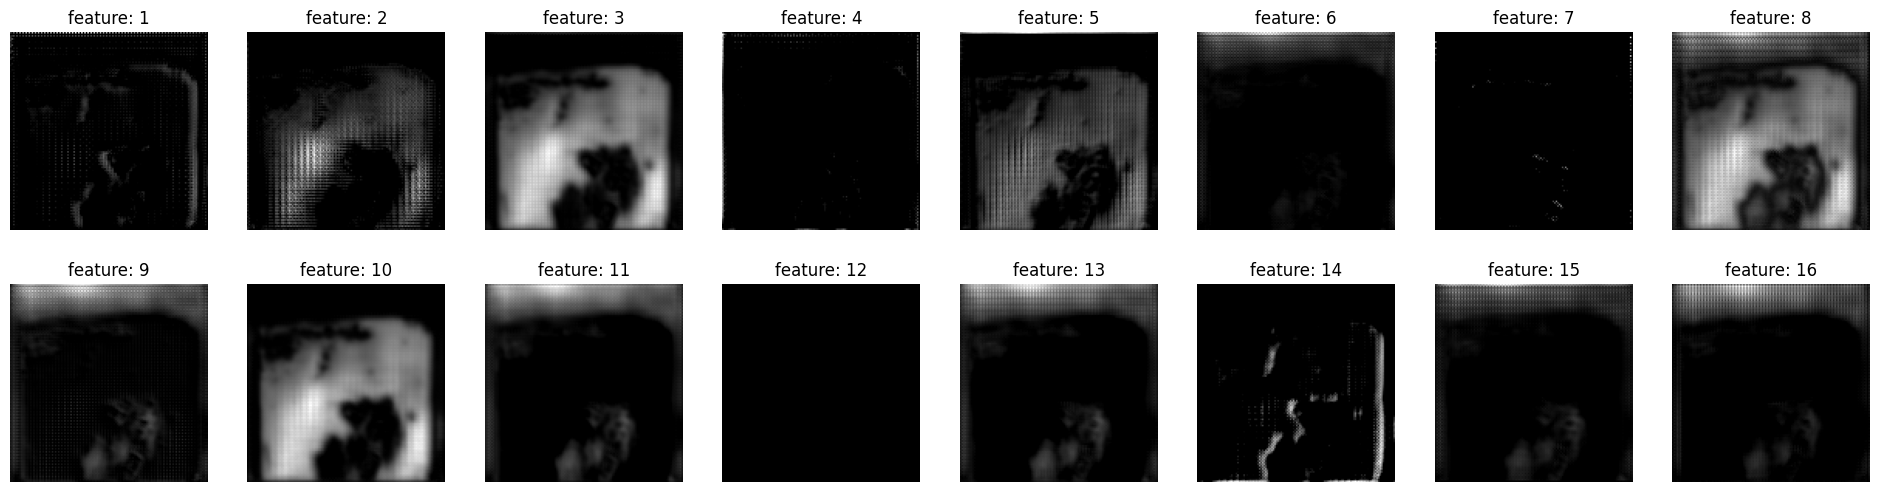

Feature map-19 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x79ea425223e0> output: (1, 256, 256, 8)


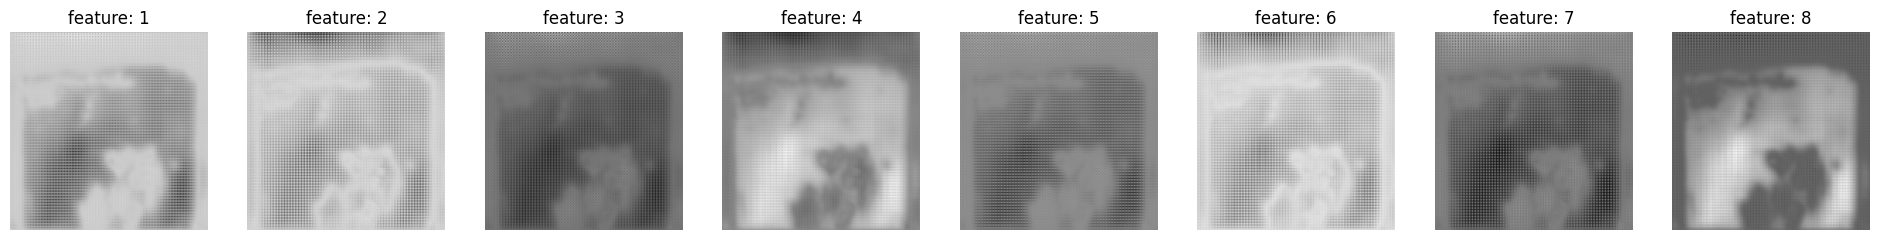

Feature map-20 <keras.src.layers.convolutional.conv2d_transpose.Conv2DTranspose object at 0x79ea42522980> output: (1, 256, 256, 8)


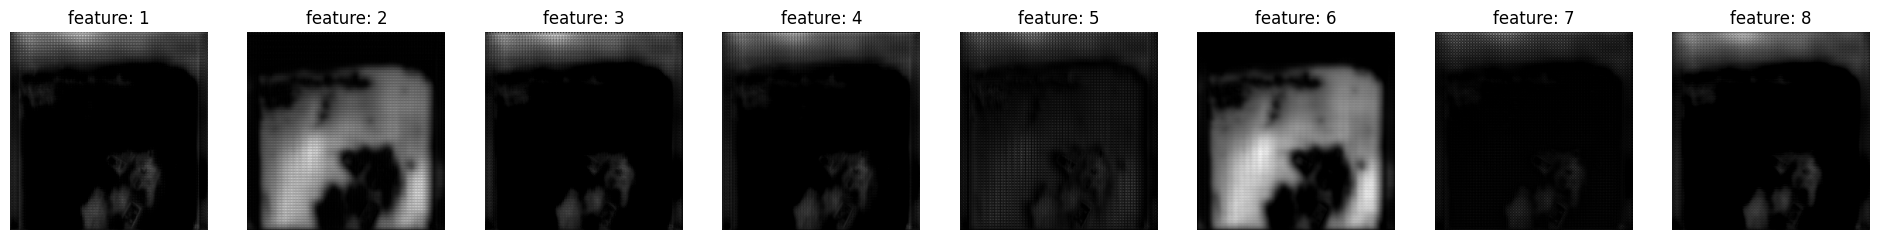

Feature map-21 <keras.src.layers.merging.concatenate.Concatenate object at 0x79ea42522ef0> output: (1, 256, 256, 8)


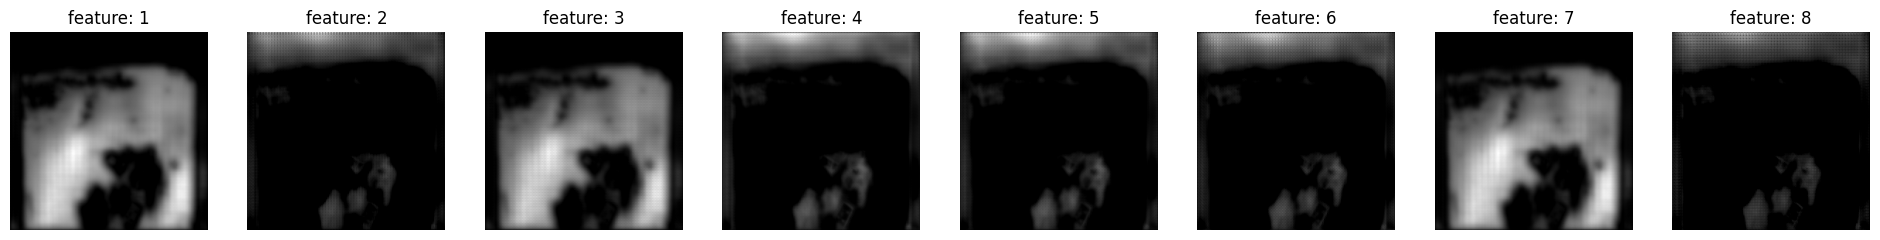

Feature map-22 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x79ea42523160> output: (1, 256, 256, 1)


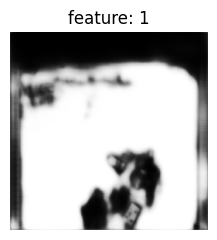

In [40]:
def plot_feature_maps(model, feature_maps):
    for i,feature_map in enumerate(feature_maps):
        print(f"Feature map-{i} {model.layers[i]} output:", feature_map.shape)
        plot_features(feature_map)
        # (batch, widh, height, num_feature)

plot_feature_maps(umodel2, umodel2_feature_maps)

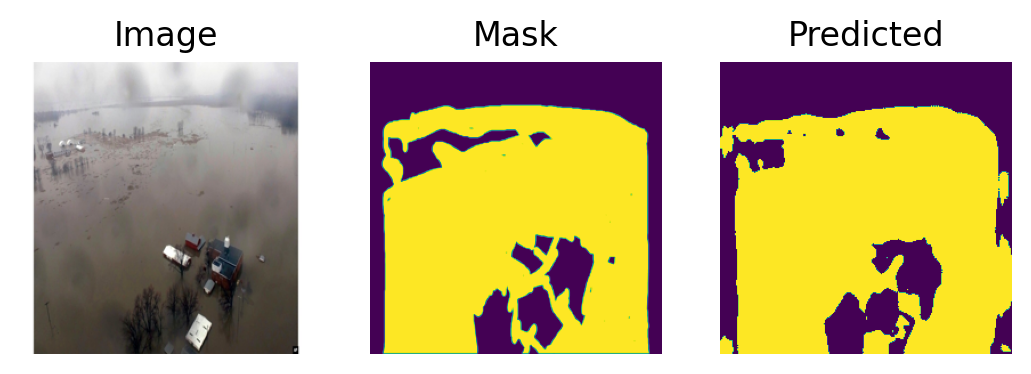

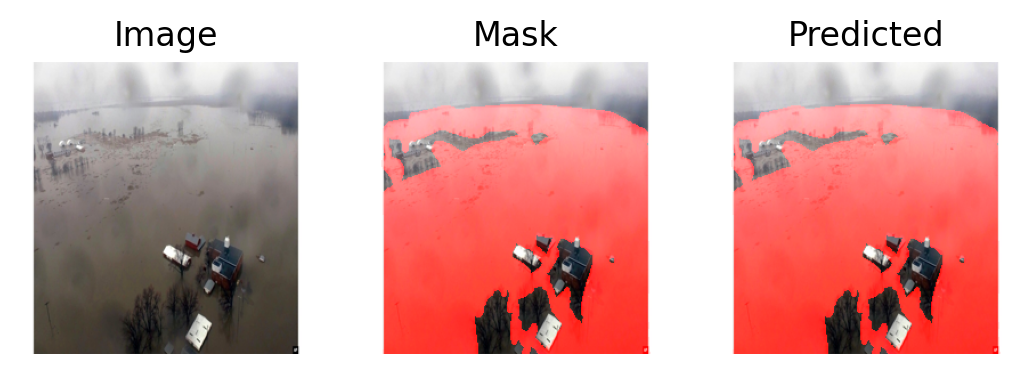

In [41]:
umodel2_last_feature_t = (umodel2_feature_maps[-1] > 0.5).squeeze(0)
X_sample = X_sample.squeeze(0)

display_images(X_sample, y_sample, umodel2_last_feature_t, title=True)

y_sample_overlay = overlay(X_sample, y_sample, color=(255,0,0), alpha=0.1)
y_pred_overlay  = overlay(X_sample, umodel2_last_feature_t, color=(255,0,0), alpha=0.25)

display_images(X_sample, y_sample_overlay, y_sample_overlay)
